## Objetivos do EDA

Este estudo de caso tem como objetivo identificar padrões que sinalizem se um cliente pode ter dificuldades em pagar as parcelas referentes aos empréstimos adquiridos na instituição financeira. As conclusões resultantes da análise auxiliarão na tomada de decisões, como:

- **Negar o empréstimo:** Quando há alto risco de inadimplência.
- **Redução do valor do empréstimo:** Para clientes com potencial de risco, mas que ainda podem receber um crédito menor.
- **Aplicação de taxas de juros mais altas:** Para candidatos considerados de maior risco.

O objetivo central da Análise Exploratória de Dados (EDA) neste estudo é identificar os fatores determinantes que indicam a inadimplência. Com isso, a empresa poderá:

- **Garantir que clientes aptos a pagar não sejam rejeitados.**
- **Entender as variáveis mais influentes na inadimplência de empréstimos.**
- **Aprimorar a avaliação de risco e gestão de portfólio** com base nos insights obtidos.

Esses tópicos guiarão a empresa na tomada de decisões mais informadas, reduzindo os riscos de crédito.

- REFERENCIA 1: https://www.kaggle.com/code/mohamedaldamrdash/loan-default-eda/notebook
- REFERENCIA 2: https://www.kaggle.com/code/phanminhquannguyen/credit-fraud-detection/notebook

## Importação das Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
import seaborn as sns
from scipy import stats
from scipy.stats import skew
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


## Carregar os dados

In [3]:
df = pd.read_csv('application_data.csv')

### Etapa 01 - Tratamento e limpeza dos dados nulos 

- Coluna de Categorização - Recebimento de documentos: Esta coluna informa se a pessoa forneceu todos os documentos exigidos ou não, e exiba o número de documentos que ela enviou.

In [4]:
docs_colunas = ['FLAG_DOCUMENT_' + str(i) for i in range(2, 22)]
df['NUM_DOCS_APRESENTADOS'] = df[docs_colunas].sum(axis=1)
flag_docs_colunas = [col for col in df.columns if col.startswith('FLAG_DOCUMENT_')]
df_exclusao_cols = df.drop(columns=flag_docs_colunas)
df = df_exclusao_cols

- Exclusão de colunas com valores nulos

In [5]:
def excluir_colunas_nulas(df, percentual):
    dados_faltantes = df.isnull().mean() * 100
    col_para_apagar = dados_faltantes[dados_faltantes > percentual].index.tolist()
    return col_para_apagar

percentual = 0
col_para_apagar = excluir_colunas_nulas(df, percentual)

# Exclui as colunas identificadas
df_exclusao_colunas = df.drop(columns=col_para_apagar)
df = df_exclusao_colunas


- Exclusão de colunas de categoria única: As colunas abaixo quase têm uma única categoria, removê-las tornará o conjunto de dados mais robusto e eficaz.

In [6]:
columns_to_drop = ['FLAG_MOBIL',
                   'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL','REG_REGION_NOT_WORK_REGION',
                   'REG_REGION_NOT_LIVE_REGION','REG_CITY_NOT_WORK_CITY','REG_CITY_NOT_LIVE_CITY']
df = df.drop(columns_to_drop,axis=1)

- Exclusão dos valores 'XNA' (essencialmente nulos) em CODE_GENDER

In [7]:
df = df[df['CODE_GENDER'] != 'XNA']

- Conversao de algumas colunas para anos

In [8]:
# Colunas que terão o sinal removido (valores absolutos)
colunas_para_remover_sinal = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
df[colunas_para_remover_sinal] = df[colunas_para_remover_sinal].abs()

# Engenharia de atributos
df['IDADE'] = df['DAYS_BIRTH'] // 365
df['ANOS_TRABALHADOS'] = df['DAYS_EMPLOYED'] // 365
df['ANOS_REGISTRO'] = df['DAYS_REGISTRATION'] // 365
df['ANOS_PUBLICACAO_ID'] = df['DAYS_ID_PUBLISH'] // 365

# Remover colunas originais
df = df.drop(colunas_para_remover_sinal, axis=1)

- Renomeando colunas

In [9]:
# Dicionário de renomeação
novos_nomes = {
    'AMT_INCOME_TOTAL': 'RENDA_TOTAL',
    'AMT_CREDIT': 'VALOR_CREDITO',
    'AGE': 'IDADE',
    'NAME_EDUCATION_TYPE': 'TIPO_EDUCACAO',
    'NAME_INCOME_TYPE': 'TIPO_RENDA',
    'NAME_HOUSING_TYPE': 'TIPO_MORADIA',
    'CODE_GENDER': 'GENERO_CODIGO',
    'NAME_CONTRACT_TYPE': 'TIPO_CONTRATO',
    'FLAG_OWN_CAR': 'POSSUI_CARRO',
    'NAME_FAMILY_STATUS': 'STATUS_FAMILIAR',
    'FLAG_PHONE': 'POSSUI_FONE',
    'FLAG_OWN_REALTY': 'POSSUI_IMOVEL',
    'REGION_POPULATION_RELATIVE': 'POPULACAO_RELATIVA_REGIAO',
    'FLAG_WORK_PHONE': 'FLAG_FONE_TRABALHO',
    'REGION_RATING_CLIENT': 'CLASSIFICACAO_REGIAO_CLIENTE',
    'WEEKDAY_APPR_PROCESS_START': 'DIA_SEMANA_INICIO_APROVACAO',
    'HOUR_APPR_PROCESS_START': 'HORA_INICIO_APROVACAO',
    'LIVE_REGION_NOT_WORK_REGION': 'REGIAO_RESIDENCIAL_DIFERENTE_REGIAO_TRABALHO',
    'LIVE_CITY_NOT_WORK_CITY': 'CIDADE_RESIDENCIAL_DIFERENTE_CIDADE_TRABALHO',
    'ORGANIZATION_TYPE': 'TIPO_ORGANIZACAO'
}

df.rename(columns=novos_nomes, inplace=True)

### Etapa 02 - EDA

- Construção de histogramas, box plots e gráficos QQ

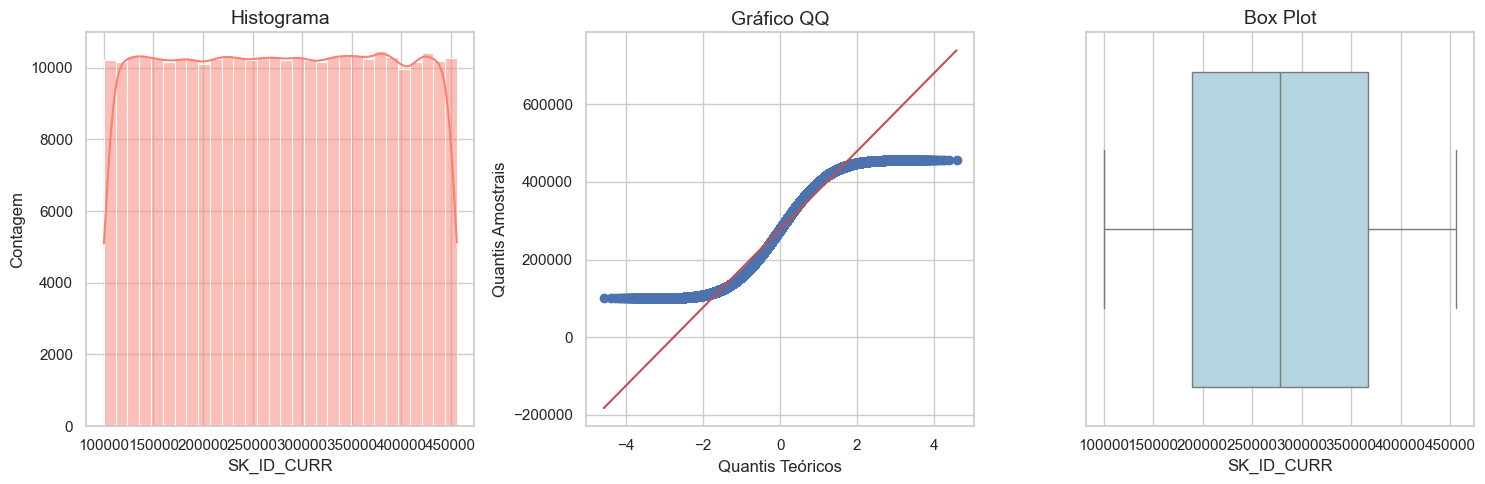

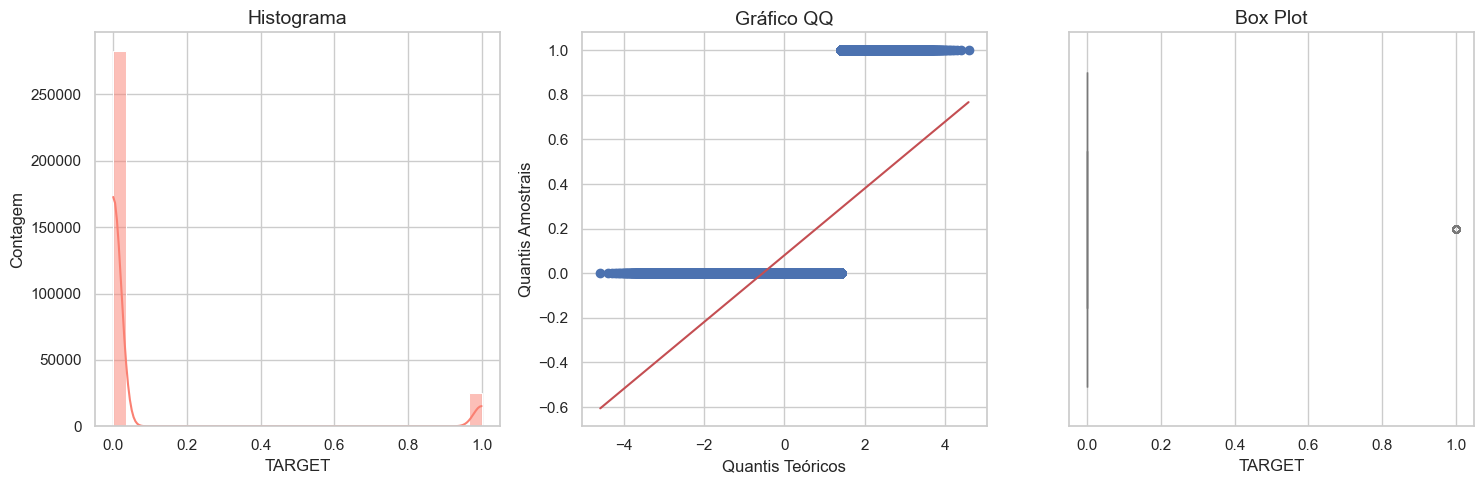

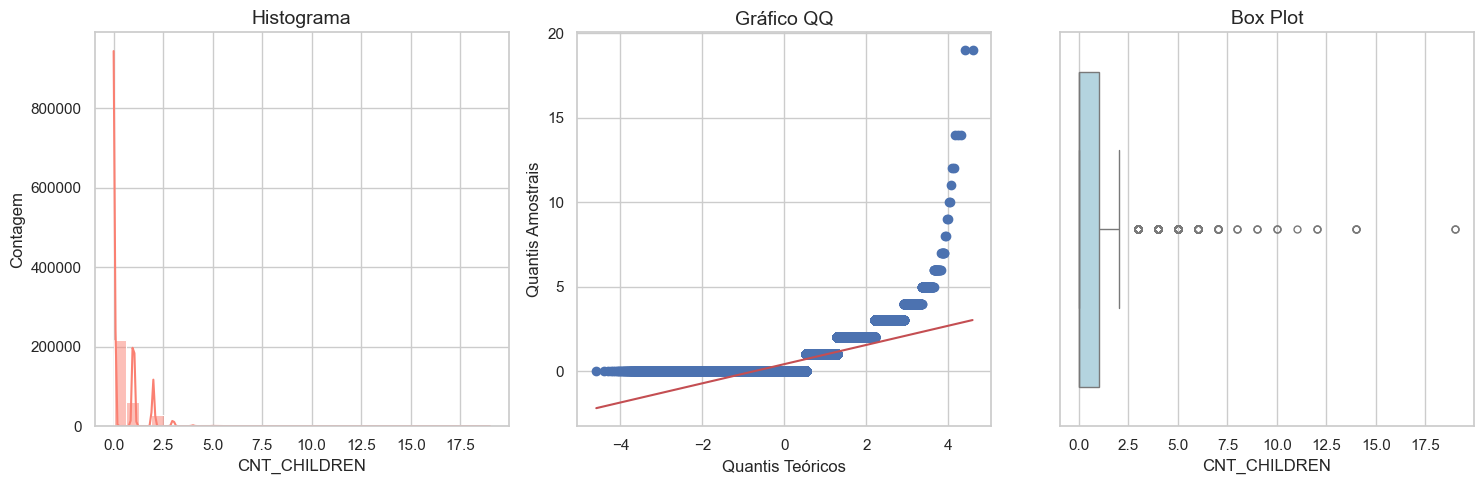

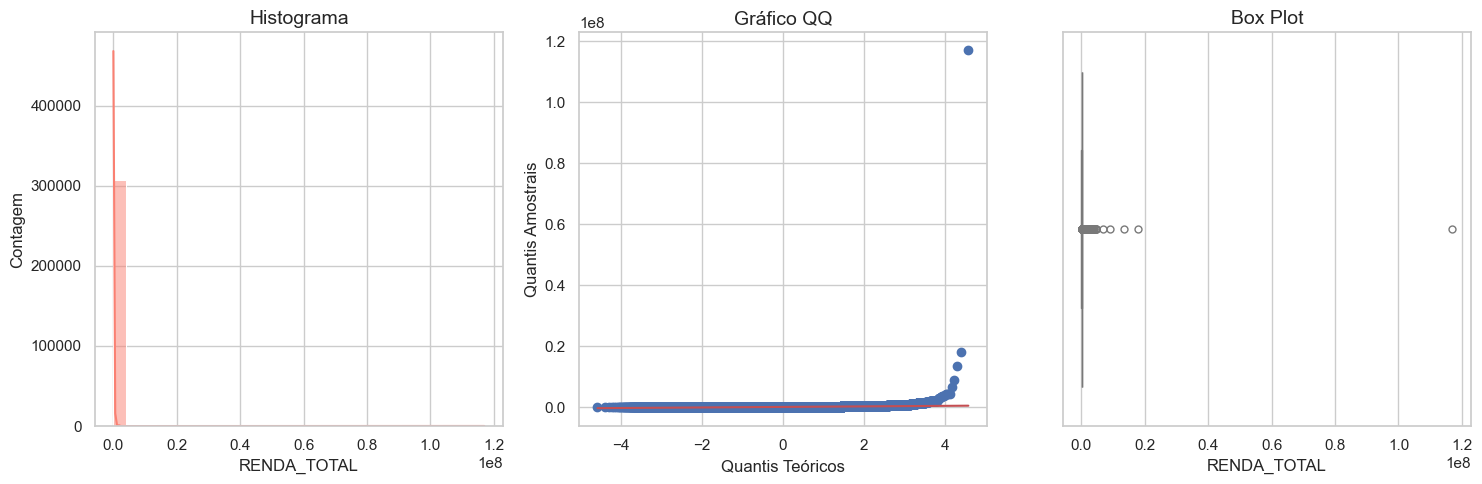

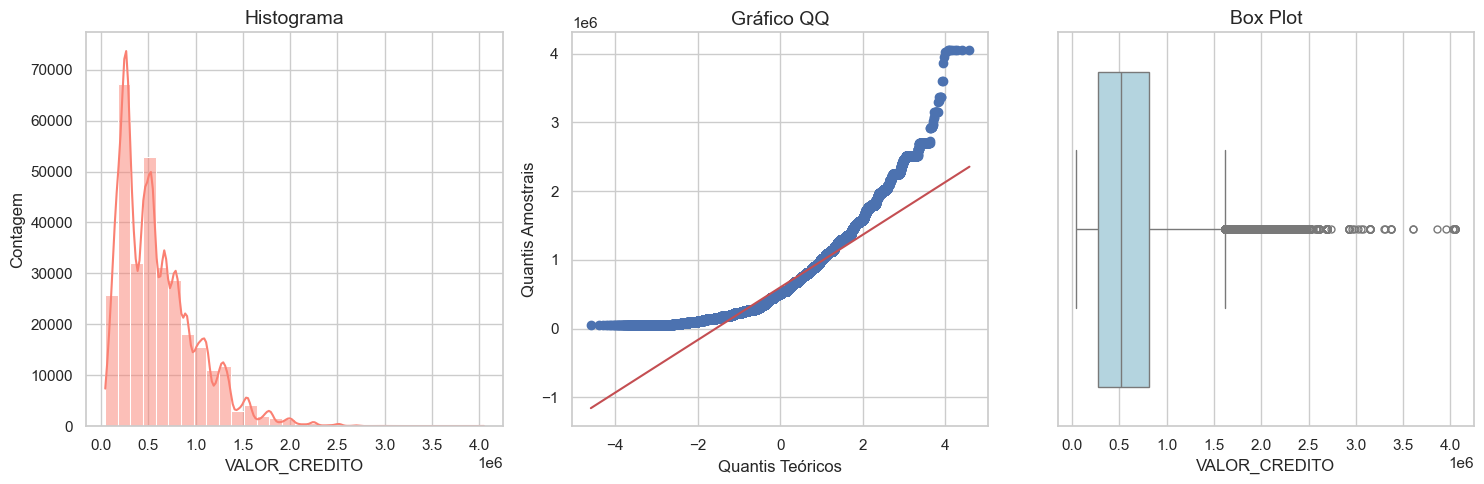

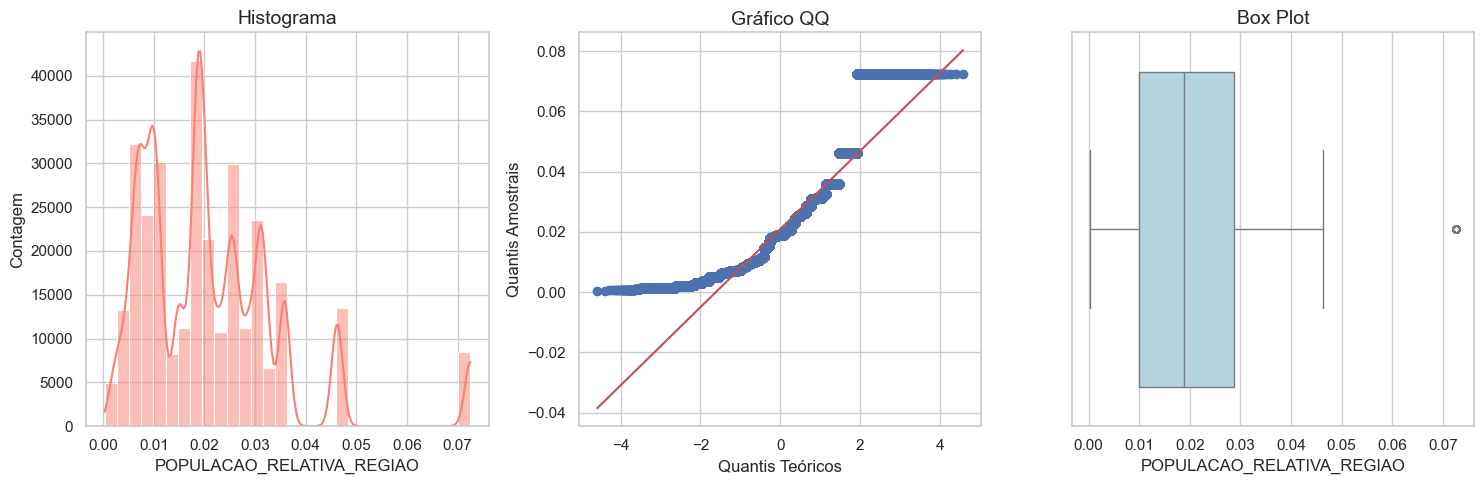

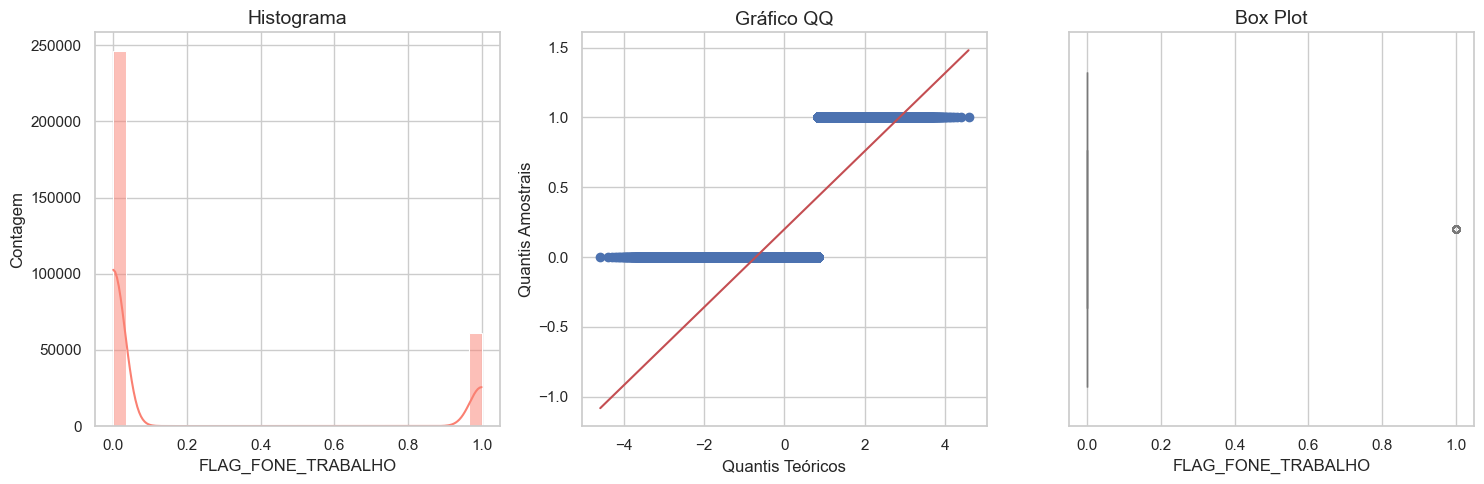

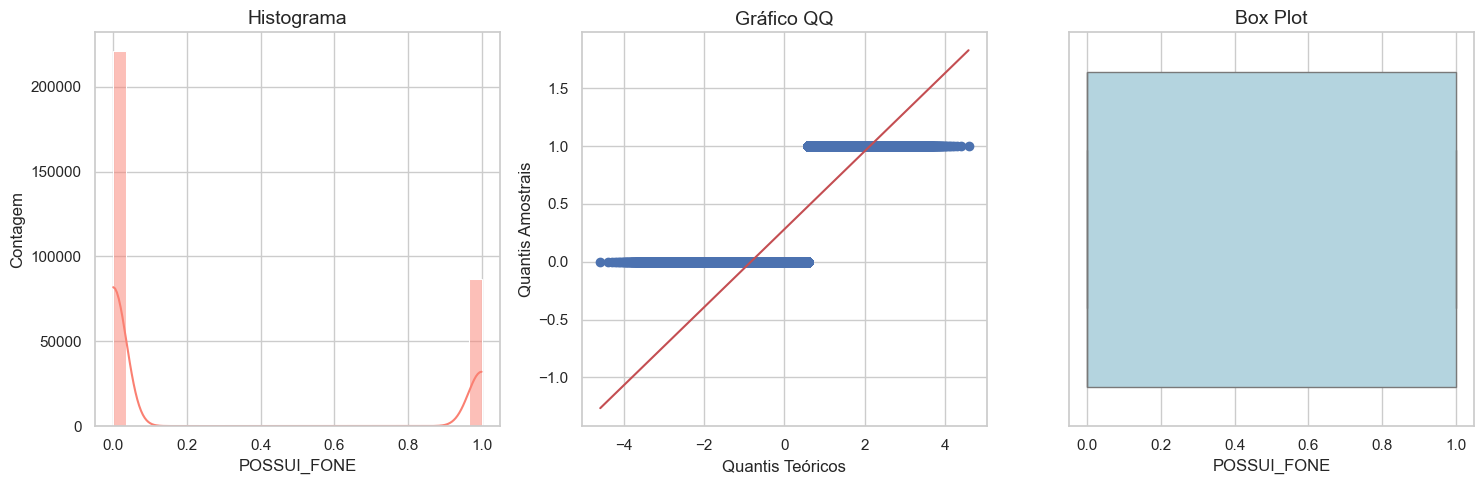

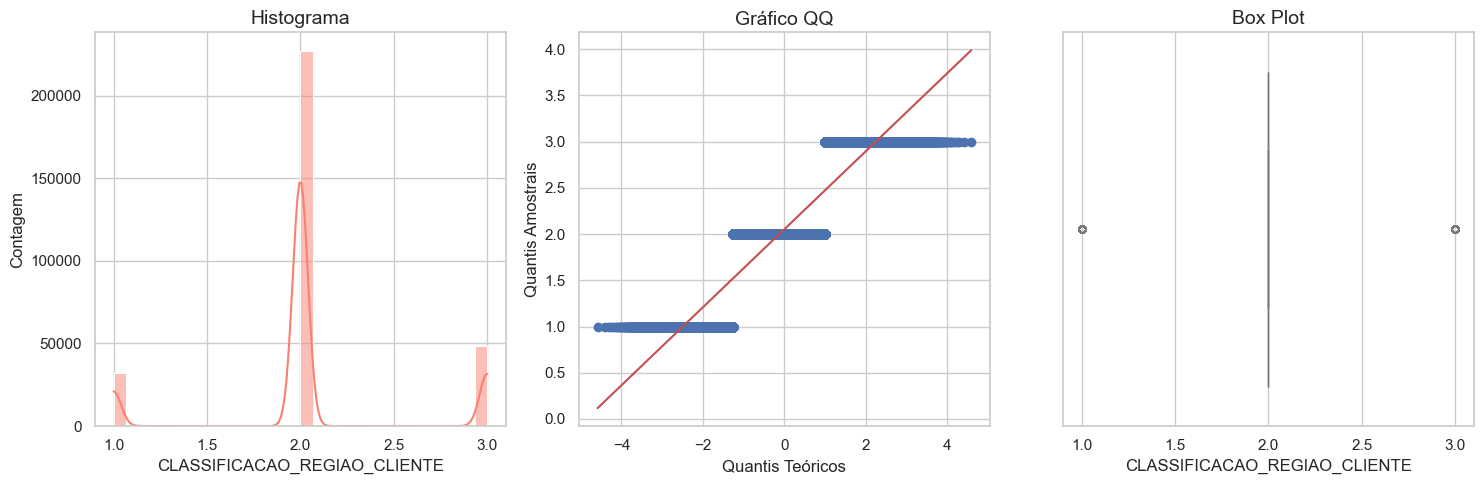

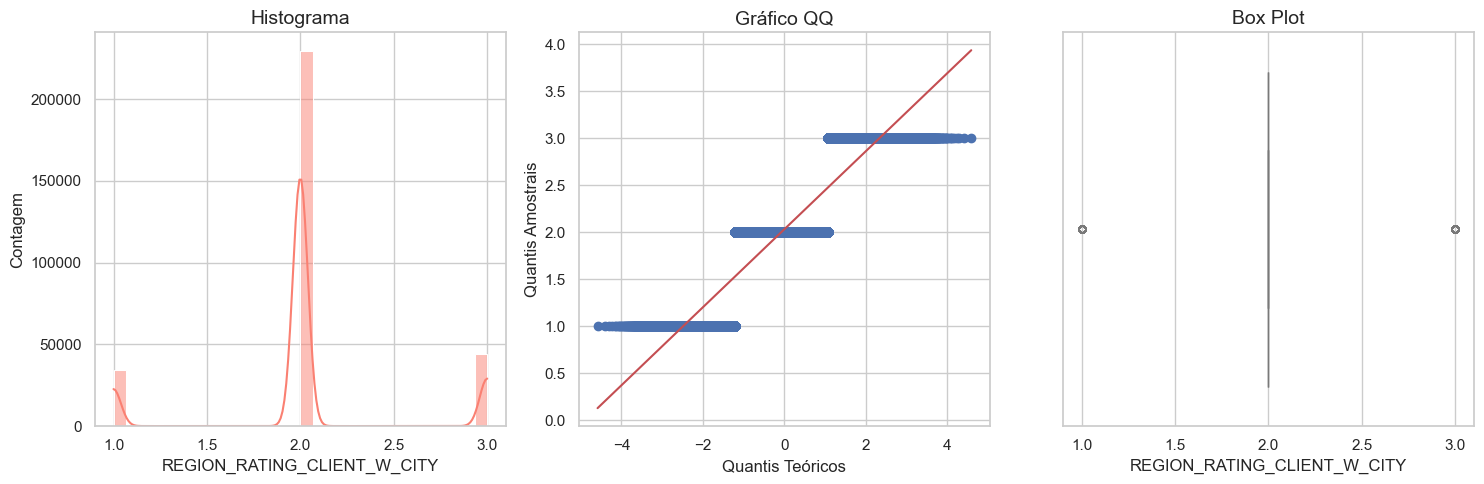

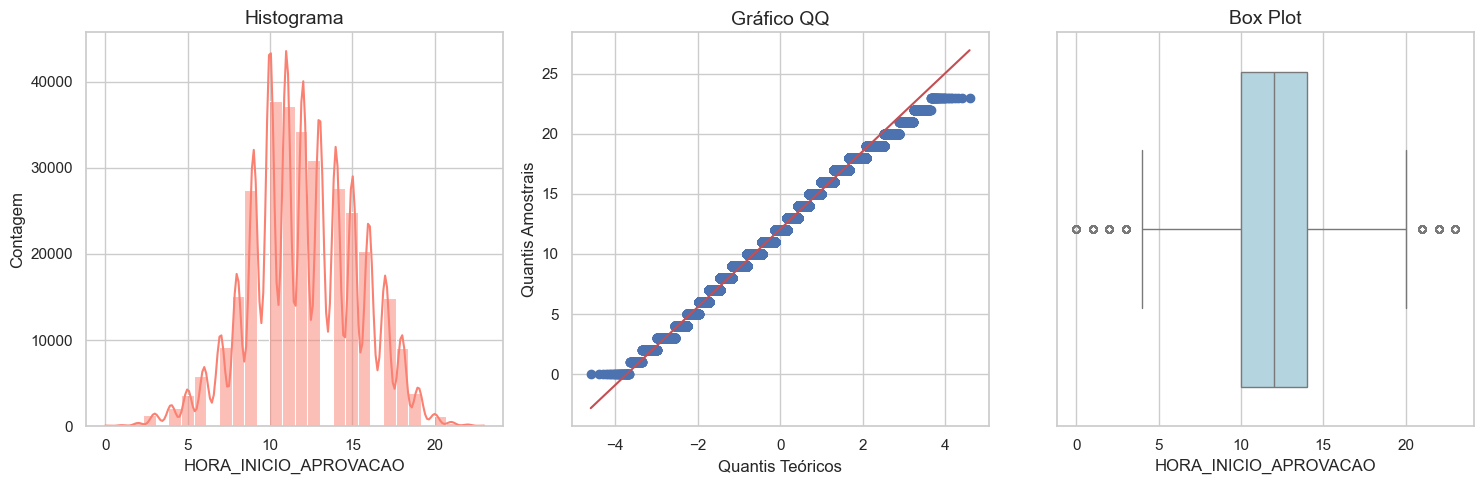

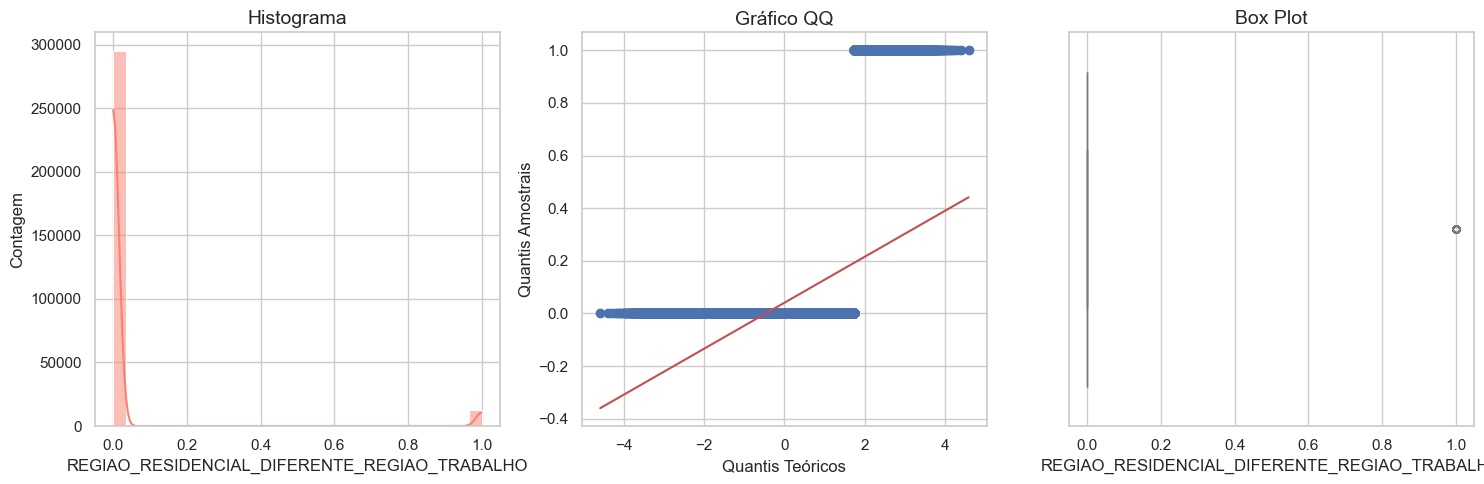

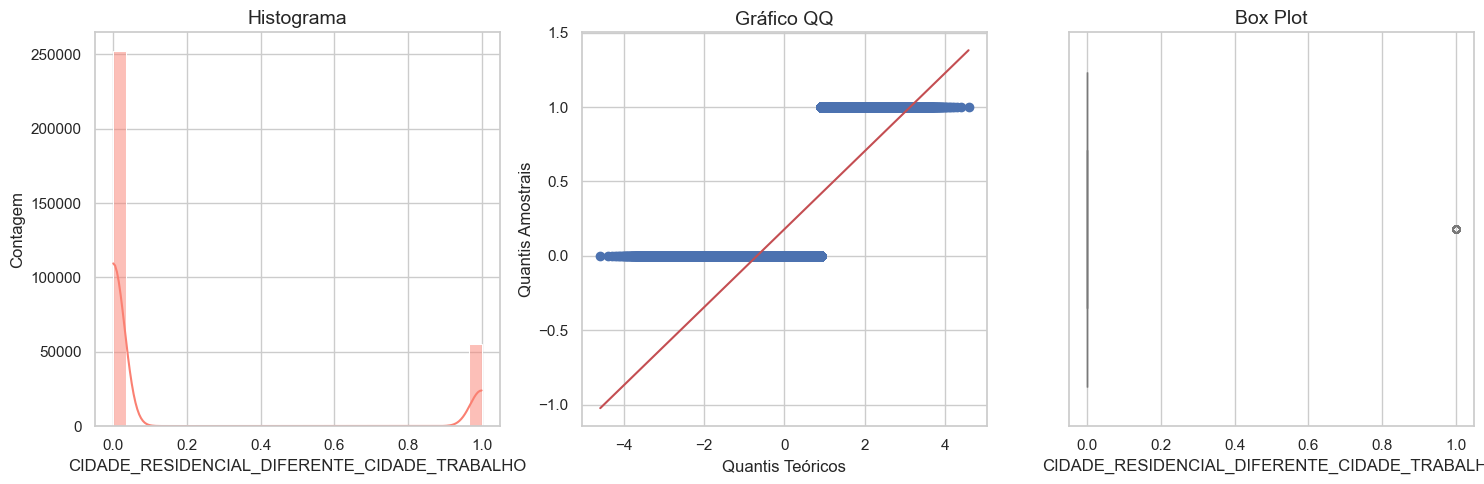

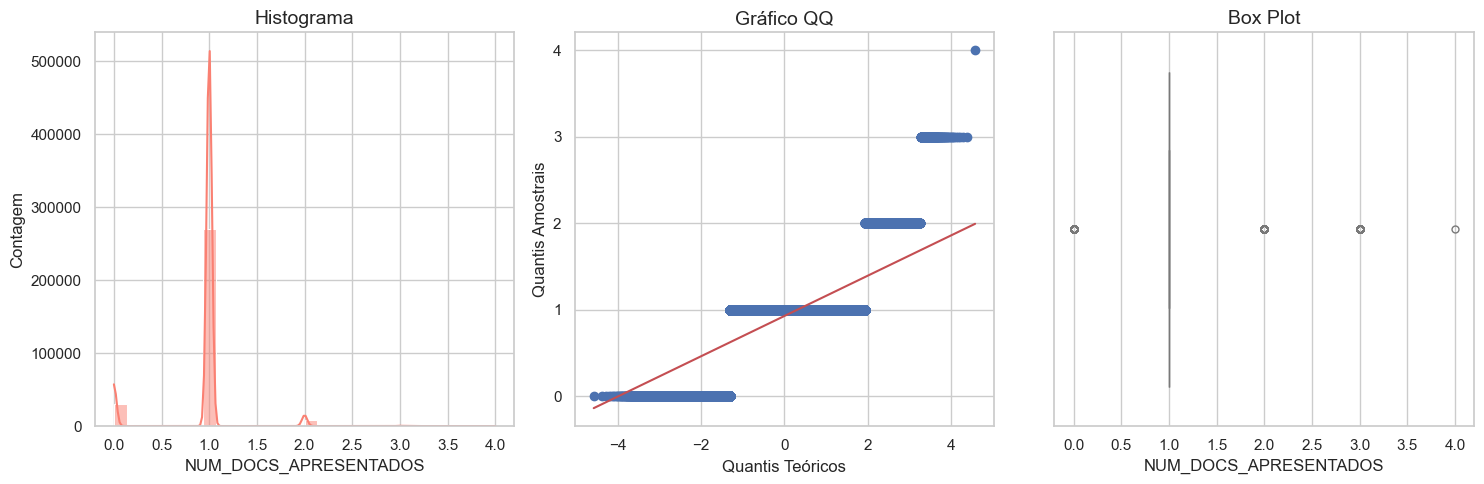

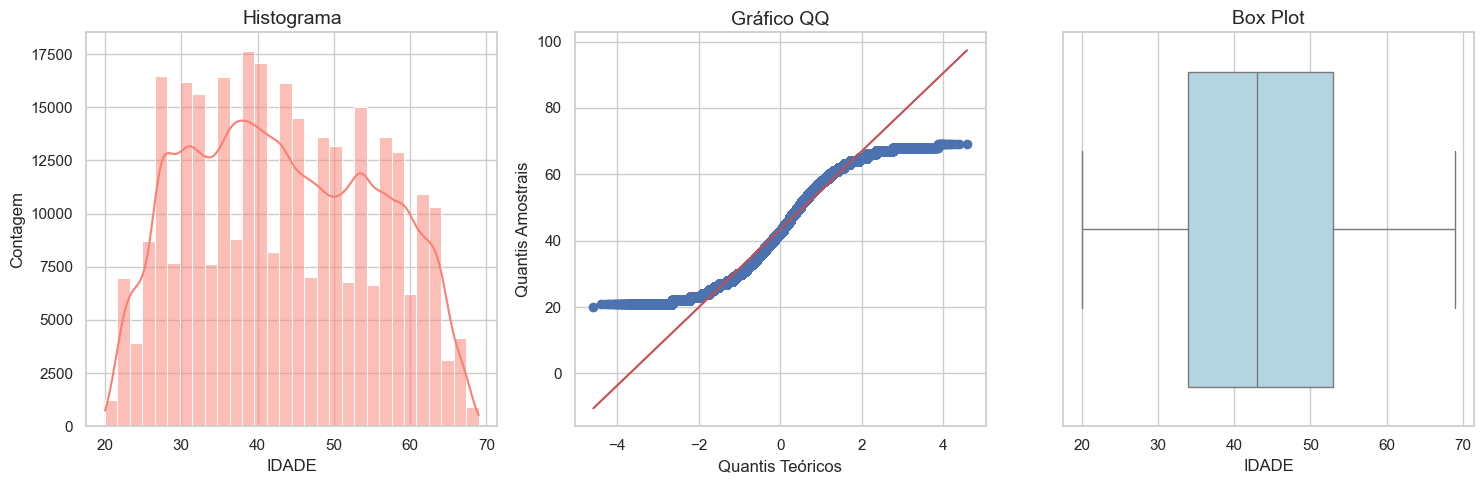

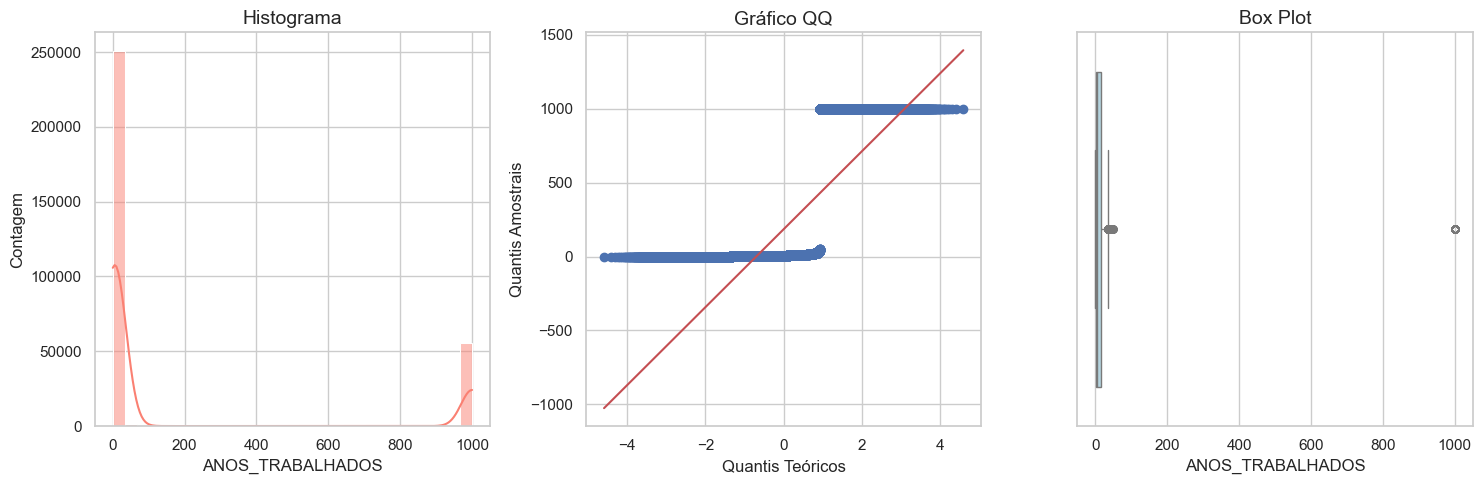

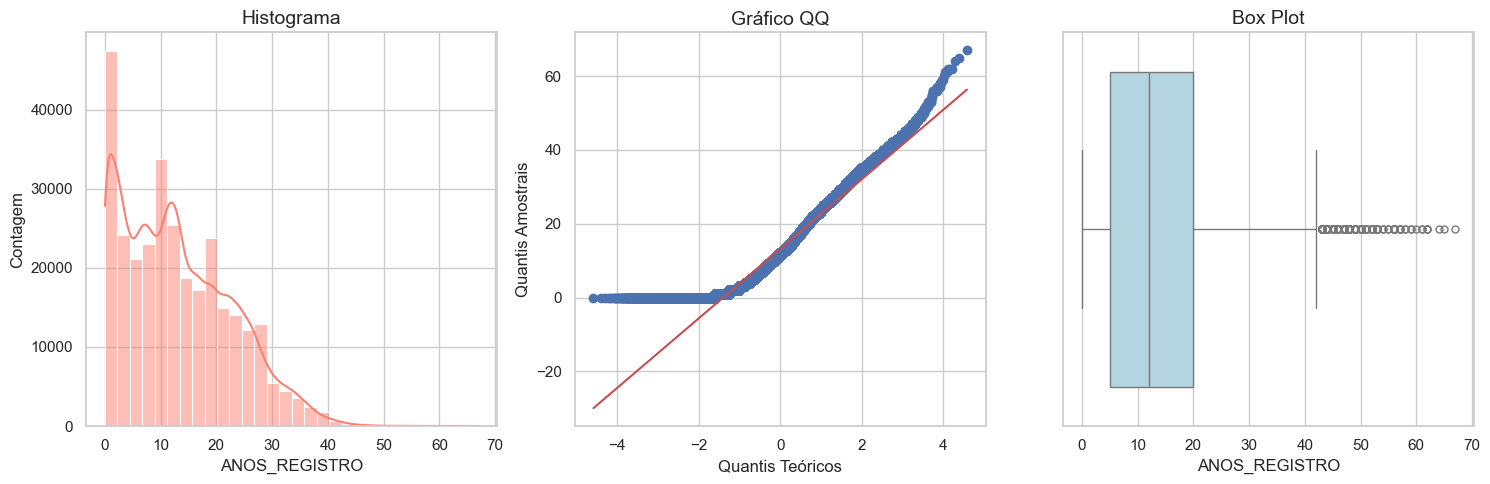

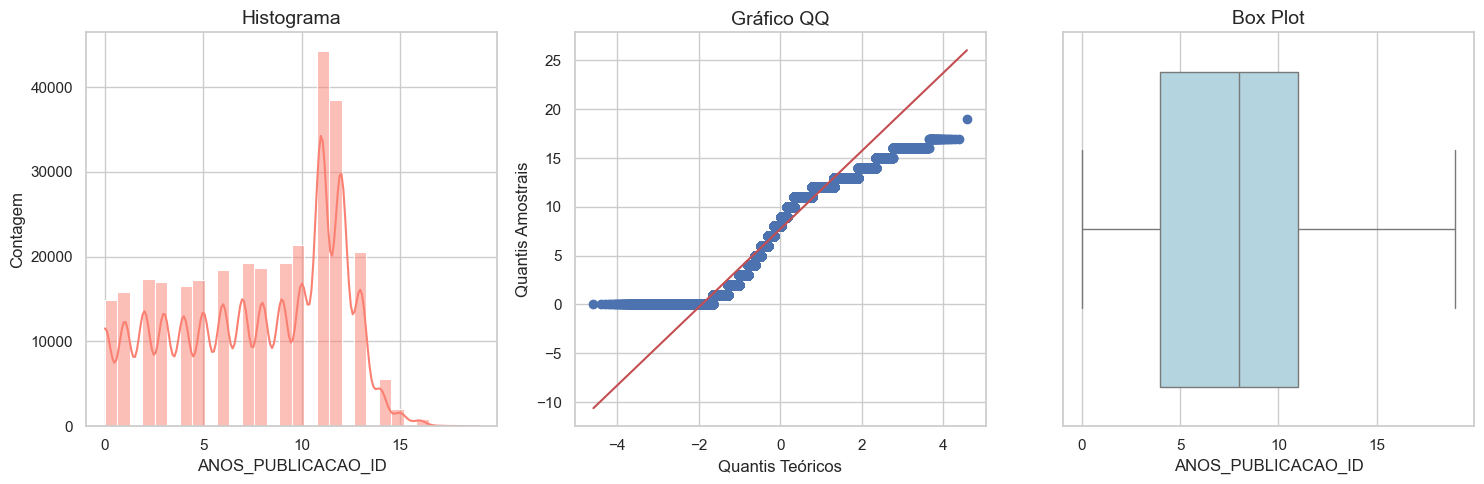

In [10]:
# Aplicar estilo dos gráficos
sns.set(style='whitegrid')

# Função para plotar análise univariada de variáveis numéricas com estilo e cores personalizados
def plotar_analise_univariada_numerica(df, nome_coluna):
    if df[nome_coluna].dtype in ['int64', 'float64']:
        plt.figure(figsize=(15, 5))

        # Histograma com cor e estilo personalizados
        plt.subplot(1, 3, 1)
        sns.histplot(df[nome_coluna], kde=True, color='salmon', bins=30)
        plt.title('Histograma', fontsize=14)
        plt.xlabel(nome_coluna, fontsize=12)
        plt.ylabel('Contagem', fontsize=12)

        # Gráfico QQ com estilo personalizado
        plt.subplot(1, 3, 2)
        stats.probplot(df[nome_coluna], dist="norm", plot=plt)
        plt.title('Gráfico QQ', fontsize=14)
        plt.xlabel('Quantis Teóricos', fontsize=12)
        plt.ylabel('Quantis Amostrais', fontsize=12)

        # Box Plot com cor e estilo personalizados
        plt.subplot(1, 3, 3)
        sns.boxplot(x=df[nome_coluna], color='lightblue', fliersize=5)
        plt.title('Box Plot', fontsize=14)
        plt.xlabel(nome_coluna, fontsize=12)

        plt.tight_layout()
        plt.show()

# Selecionar colunas numéricas
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns

# Plotar para cada coluna numérica
for coluna in colunas_numericas:
    plotar_analise_univariada_numerica(df, coluna)


- Analisando colunas com outliers

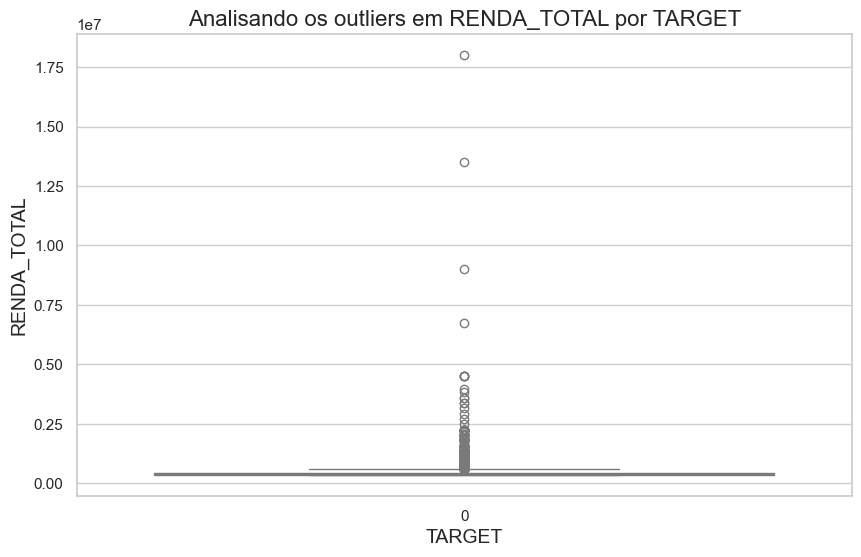

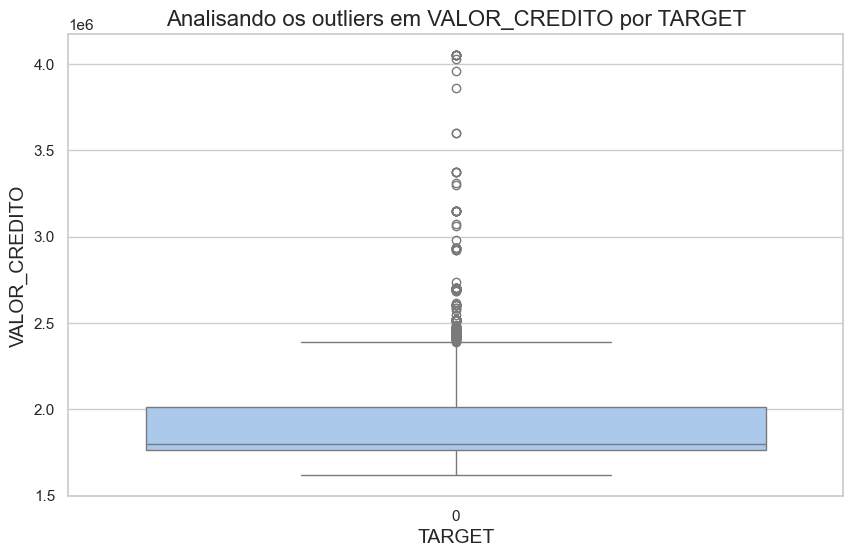

In [11]:
sns.set(style='whitegrid')

outliers = {}
for coluna in ['RENDA_TOTAL', 'VALOR_CREDITO']:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers[coluna] = df[(df['TARGET'] == 0) & ((df[coluna] < limite_inferior) | (df[coluna] > limite_superior))]

for coluna, df_outliers in outliers.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TARGET', y=coluna, data=df_outliers, palette='pastel')
    plt.title(f'Analisando os outliers em {coluna} por TARGET', fontsize=16)
    plt.xlabel('TARGET', fontsize=14)
    plt.ylabel(coluna, fontsize=14)
    plt.show()


### Etapa 03 - Análises do EDA

- Análise 1: Colunas com target 0 e 1

In [12]:
# Função para calcular estatísticas resumo
def estatisticas_resumo(serie):
    return pd.Series({
        'média': serie.mean(),
        'mediana': serie.median(),
        'desvio padrão': serie.std(),
        'iqr': serie.quantile(0.75) - serie.quantile(0.25),
        'variância': serie.var(),
        'mínimo': serie.min(),
        'máximo': serie.max()
    })

# Especificar as colunas numéricas a serem analisadas
colunas_numericas = ['RENDA_TOTAL', 'VALOR_CREDITO', 'IDADE']

# Filtrar dados para 'TARGET' == 0 e 'TARGET' == 1 separadamente
estatisticas_target_0 = df[df['TARGET'] == 0][colunas_numericas].apply(estatisticas_resumo).T
estatisticas_target_1 = df[df['TARGET'] == 1][colunas_numericas].apply(estatisticas_resumo).T

print("******************* Estatísticas Resumo para TARGET == 0 ********************************")
print(estatisticas_target_0)

print("\n******************* Estatísticas Resumo para TARGET == 1 ********************************")
print(estatisticas_target_1)

print("\n******************* Conclusões ********************************")
print("Indivíduos com TARGET == 1 tendem a ter uma renda média e valores de crédito ligeiramente inferiores")
print("em comparação com aqueles com TARGET == 0. O desvio padrão e o intervalo de valores para renda e")
print("valores de crédito são significativamente maiores para TARGET == 1, indicando um perfil financeiro")
print("mais diversificado nesta categoria.")


******************* Estatísticas Resumo para TARGET == 0 ********************************
                       média   mediana  desvio padrão       iqr     variância  \
RENDA_TOTAL    169077.472200  148500.0  110476.907925   90000.0  1.220515e+10   
VALOR_CREDITO  602651.158355  517788.0  406847.907496  540000.0  1.655252e+11   
IDADE              43.713222      43.0      11.955270      20.0  1.429285e+02   

                mínimo      máximo  
RENDA_TOTAL    25650.0  18000090.0  
VALOR_CREDITO  45000.0   4050000.0  
IDADE             20.0        69.0  

******************* Estatísticas Resumo para TARGET == 1 ********************************
                       média   mediana  desvio padrão       iqr     variância  \
RENDA_TOTAL    165611.760906  135000.0  746676.959440   90000.0  5.575265e+11   
VALOR_CREDITO  557778.527674  497520.0  346433.235646  448915.5  1.200160e+11   
IDADE              40.279960      39.0      11.484458      18.0  1.318928e+02   

                mínim

- Análise 2: Profissão/Formação Acadêmica x Renda 

In [13]:
# Agrupar os dados por 'TIPO_EDUCACAO' e 'TIPO_RENDA' e calcular as estatísticas
estatisticas_educacao_renda = df.groupby(['TIPO_EDUCACAO', 'TIPO_RENDA']).agg({
    'RENDA_TOTAL': ['mean', 'median', 'count', 'max']
})

#mean: média
#median: mediana
#count: contagem
#max: máximo

print(estatisticas_educacao_renda)
print('\nConclusões Resumidas:')
print('- Empresários e associados comerciais com ensino superior geralmente têm rendas mais altas.')
print('- Associados comerciais com diferentes níveis educacionais apresentam faixas de renda variadas, refletindo o impacto da indústria.')
print('- Indivíduos com ensino médio, especialmente empregados, têm uma ampla gama de rendas, sugerindo diversas oportunidades de carreira.')
print('- Pensionistas, servidores públicos e empregados com variados níveis educacionais mostram padrões variados de renda.')
print('- Valores discrepantes em faixas de renda amplas podem exigir investigação para entender os fatores que contribuem para esses extremos.')


                                                      RENDA_TOTAL            \
                                                             mean    median   
TIPO_EDUCACAO                 TIPO_RENDA                                      
Academic degree               Commercial associate  274688.372093  247500.0   
                              Pensioner             203919.230769  155700.0   
                              State servant         258847.826087  225000.0   
                              Working               226312.500000  202500.0   
Higher education              Businessman           652500.000000  495000.0   
                              Commercial associate  242283.998486  202500.0   
                              Maternity leave       195000.000000  135000.0   
                              Pensioner             171455.114974  148500.0   
                              State servant         207116.161080  180000.0   
                              Student               

- Análise 3: Sexo x inadimplência e ter carro ou nao

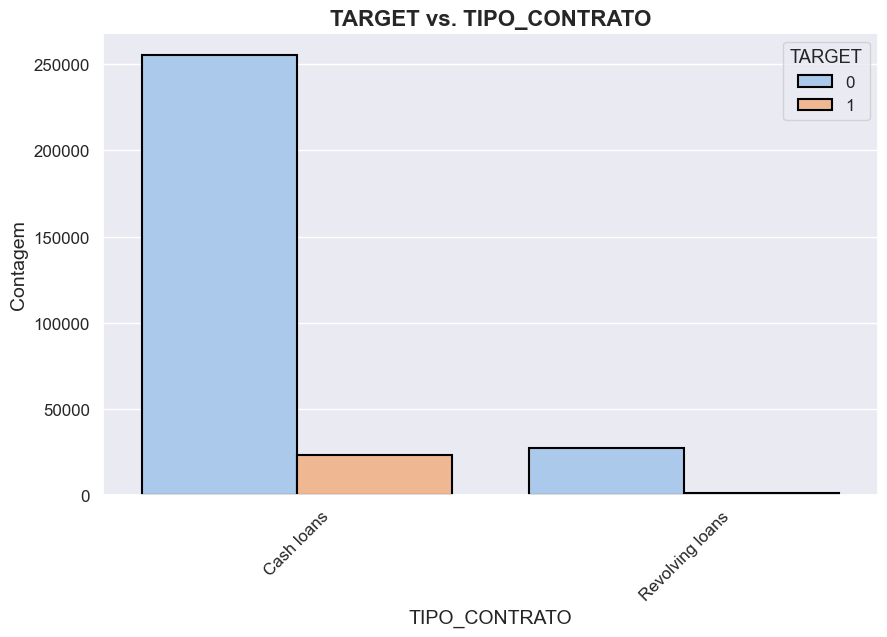

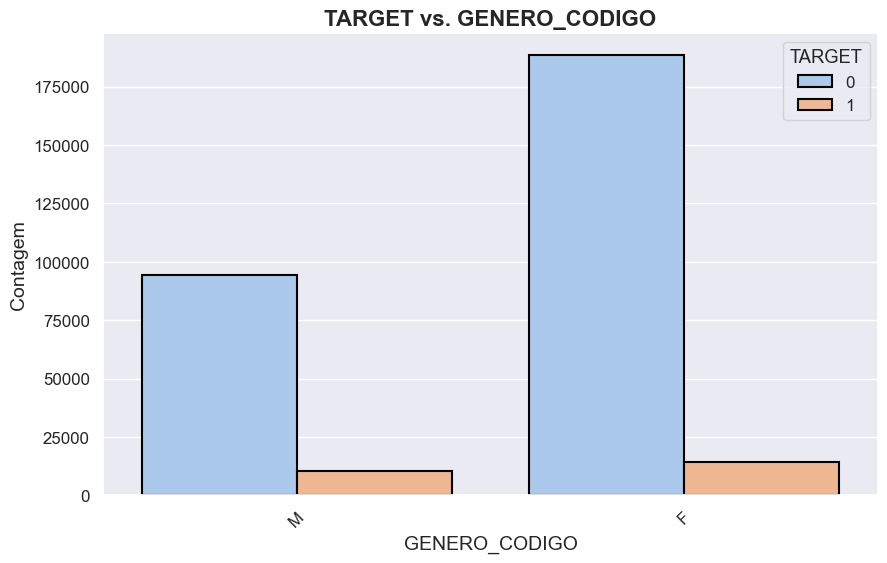

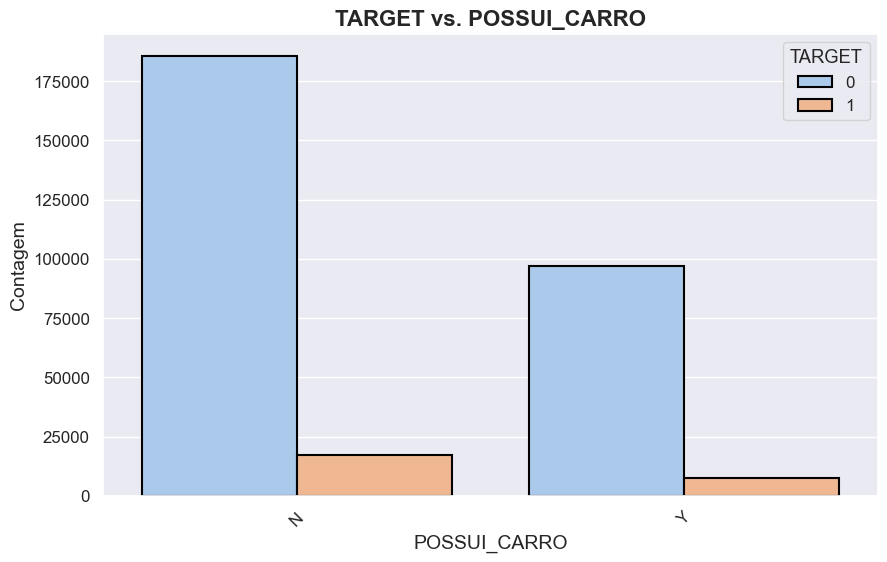

Conclusões:

1. Empréstimos em dinheiro apresentam maiores taxas de inadimplência.
2. Homens possuem menor número de empréstimos, mas maior taxa de inadimplência em comparação com mulheres, sugerindo que o gênero pode influenciar o comportamento no pagamento de empréstimos.
3. A posse de um carro não afeta significativamente a inadimplência, pois as taxas são similares para quem possui ou não carro.



In [14]:
colunas_bivariadas = ['TIPO_CONTRATO', 'GENERO_CODIGO', 'POSSUI_CARRO', 'RENDA_TOTAL', 'VALOR_CREDITO', 'IDADE']

# Definir um estilo diferente para os gráficos
sns.set(style="darkgrid", palette="pastel", font_scale=1.1)

for coluna in colunas_bivariadas:
    if df[coluna].dtype == 'O' or df[coluna].dtype.name == 'category':
        # Variáveis categóricas
        plt.figure(figsize=(10, 6))
        sns.countplot(x=coluna, hue="TARGET", data=df, edgecolor="black", linewidth=1.5)
        plt.title(f'TARGET vs. {coluna}', fontsize=16, weight='bold')
        plt.xlabel(coluna, fontsize=14)
        plt.ylabel('Contagem', fontsize=14)
        plt.xticks(rotation=45)
        plt.show()
    else:
        continue

# Exibir conclusões resumidas em tópicos
print('Conclusões:')
print('''
1. Empréstimos em dinheiro apresentam maiores taxas de inadimplência.
2. Homens possuem menor número de empréstimos, mas maior taxa de inadimplência em comparação com mulheres, sugerindo que o gênero pode influenciar o comportamento no pagamento de empréstimos.
3. A posse de um carro não afeta significativamente a inadimplência, pois as taxas são similares para quem possui ou não carro.
''')


- Análise 4: Número de documentos apresentados x Inadimplência 

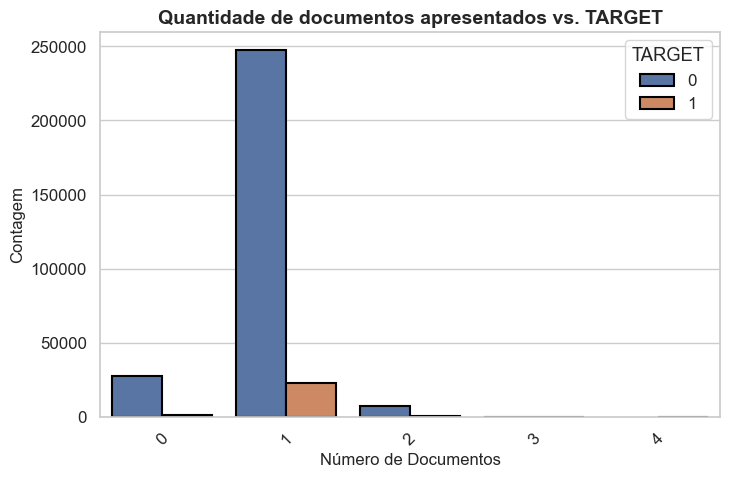

Conclusões:

1. Indivíduos que apresentam menos documentos tendem a ter menor inadimplência.
2. Categorias com 100% de inadimplência devem ser analisadas com cautela, pois podem não representar adequadamente a população.
3. O número de documentos pode estar correlacionado ao risco de inadimplência, sendo um fator a ser monitorado.



In [15]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", palette="deep", font_scale=1.1)

sns.countplot(x='NUM_DOCS_APRESENTADOS', hue='TARGET', data=df, edgecolor="black", linewidth=1.5)
plt.title('Quantidade de documentos apresentados vs. TARGET', fontsize=14, weight='bold')
plt.xlabel('Número de Documentos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print('Conclusões:')
print('''
1. Indivíduos que apresentam menos documentos tendem a ter menor inadimplência.
2. Categorias com 100% de inadimplência devem ser analisadas com cautela, pois podem não representar adequadamente a população.
3. O número de documentos pode estar correlacionado ao risco de inadimplência, sendo um fator a ser monitorado.
''')


- Análise 5: Tipo de Educacao e Moradia x Inadimplencia

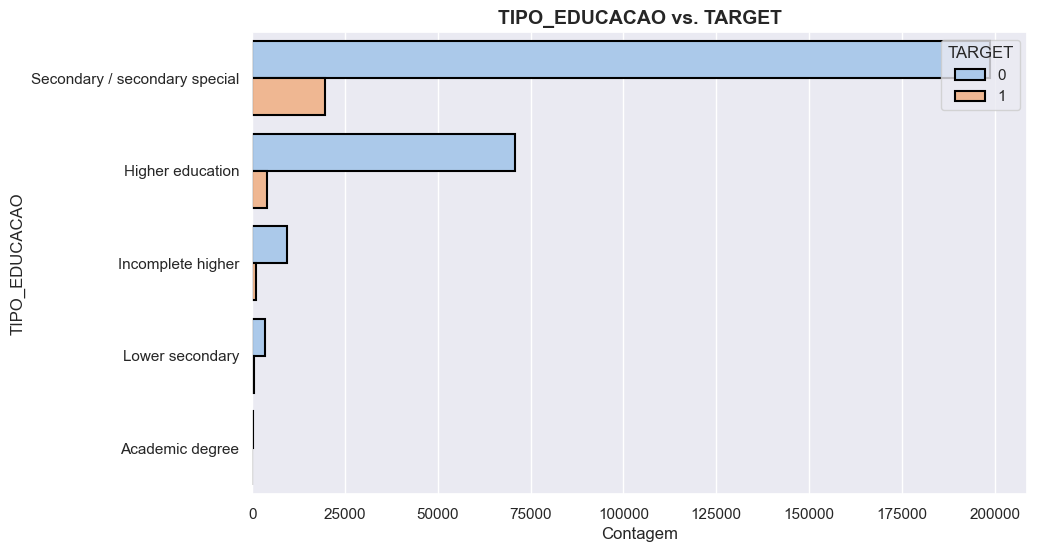

Conclusão sobre Nível de Educação:

1. Indivíduos com níveis mais altos de educação (como ensino superior) tendem a ter taxas de inadimplência mais baixas.
2. As taxas de inadimplência são mais altas entre pessoas com níveis educacionais mais baixos.



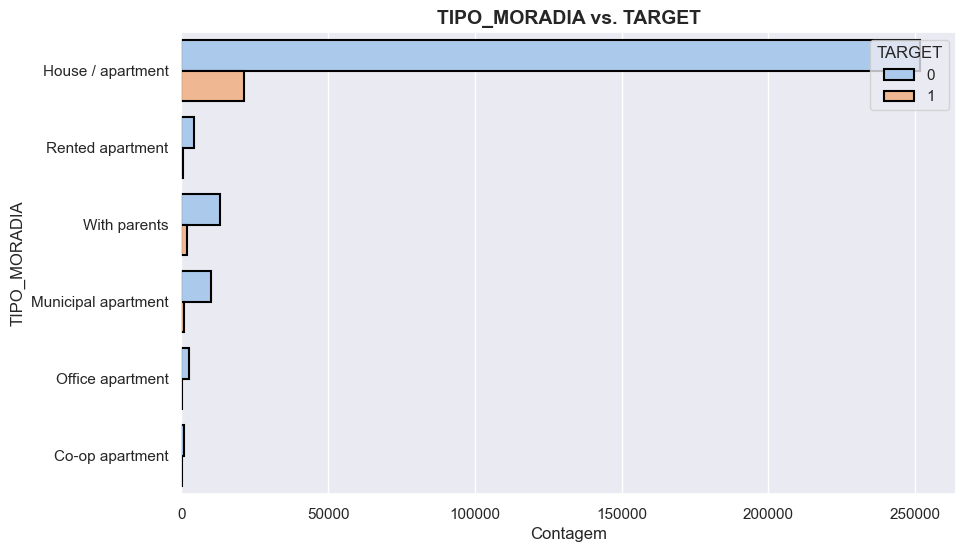

Conclusão sobre Tipo de Moradia:

1. Pessoas que moram em apartamentos alugados ou com parentes apresentam taxas de inadimplência mais altas.
2. A posse de imóveis parece estar relacionada a uma menor taxa de inadimplência.

Conclusão geral sobre Ocupação:

Profissões de baixa qualificação estão associadas a taxas de inadimplência mais elevadas.
Compreender esses padrões pode auxiliar na análise de risco e na formulação de estratégias para perfis de clientes específicos.



In [16]:
sns.set(style="darkgrid", palette="pastel")

# Gráfico 1 - Nível de Educação vs. TARGET
plt.figure(figsize=(10, 6))
sns.countplot(y='TIPO_EDUCACAO', hue='TARGET', data=df, edgecolor='black', linewidth=1.5)
plt.title('TIPO_EDUCACAO vs. TARGET', fontsize=14, fontweight='bold')
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('TIPO_EDUCACAO', fontsize=12)
plt.legend(title='TARGET', loc='upper right')
plt.show()

print('Conclusão sobre Nível de Educação:')
print('''
1. Indivíduos com níveis mais altos de educação (como ensino superior) tendem a ter taxas de inadimplência mais baixas.
2. As taxas de inadimplência são mais altas entre pessoas com níveis educacionais mais baixos.
''')

# Gráfico 2 - Tipo de Moradia vs. TARGET
plt.figure(figsize=(10, 6))
sns.countplot(y='TIPO_MORADIA', hue='TARGET', data=df, edgecolor='black', linewidth=1.5)
plt.title('TIPO_MORADIA vs. TARGET', fontsize=14, fontweight='bold')
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('TIPO_MORADIA', fontsize=12)
plt.legend(title='TARGET', loc='upper right')
plt.show()

print('Conclusão sobre Tipo de Moradia:')
print('''
1. Pessoas que moram em apartamentos alugados ou com parentes apresentam taxas de inadimplência mais altas.
2. A posse de imóveis parece estar relacionada a uma menor taxa de inadimplência.
''')

print('Conclusão geral sobre Ocupação:')
print('''
Profissões de baixa qualificação estão associadas a taxas de inadimplência mais elevadas.
Compreender esses padrões pode auxiliar na análise de risco e na formulação de estratégias para perfis de clientes específicos.
''')

- Análise 6: Correlação entre Renda Total e Valor do Crédito

Gráfico 1: Dispersão


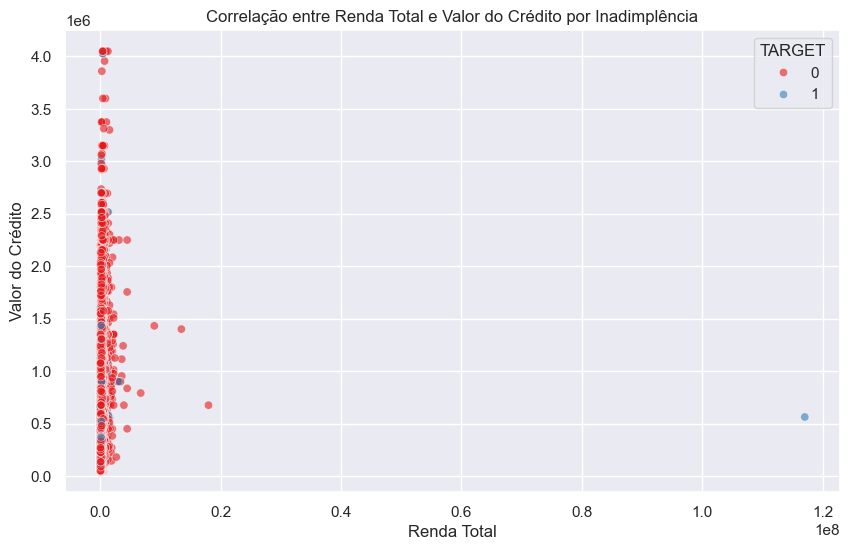

Gráficos 2: Boxplots da Renda Total e de Crédito


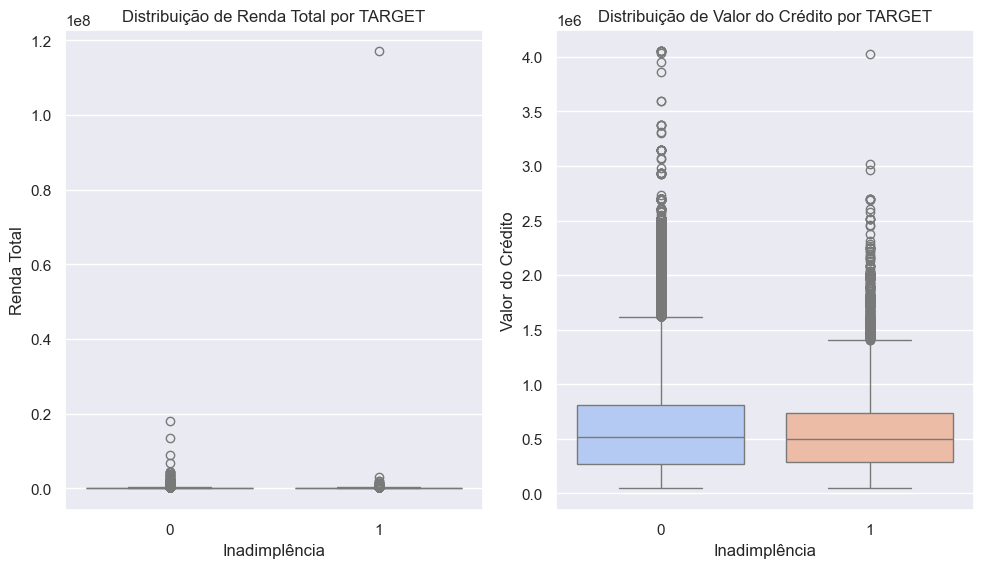

Conclusões:
1. Correlação Positiva: Existe uma correlação positiva entre renda total e valor do crédito. 
   Isso indica que, de maneira geral, pessoas com rendas mais altas tendem a solicitar valores de crédito maiores.
Gráficos 3: Barras por Faixa de Renda e Valor de Crédito


<Figure size 1200x600 with 0 Axes>

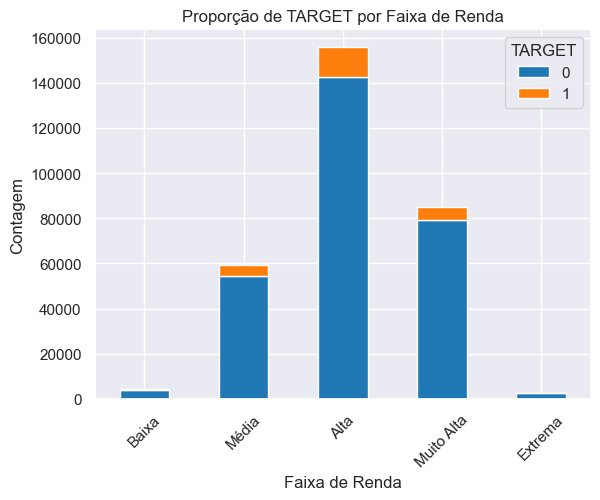

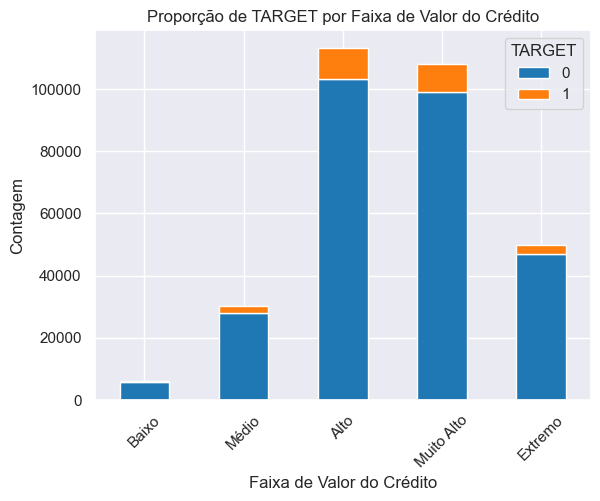

Conclusões:

2. Distribuição Similar: Em ambos os grupos (inadimplentes e não inadimplentes), a relação entre renda e valor do crédito é similar, 
   sugerindo que a decisão de concessão de crédito não difere drasticamente entre esses dois grupos.

3. Variabilidade: Indivíduos com rendas muito altas ou valores de crédito muito elevados são mais raros, o que pode indicar que 
   há restrições para a concessão de grandes valores de crédito, independente da renda.



In [17]:
print('Gráfico 1: Dispersão')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RENDA_TOTAL', y='VALOR_CREDITO', hue='TARGET', alpha=0.6, palette='Set1')
plt.title('Correlação entre Renda Total e Valor do Crédito por Inadimplência')
plt.xlabel('Renda Total')
plt.ylabel('Valor do Crédito')
plt.show()

plt.figure(figsize=(10, 6))

print('Gráficos 2: Boxplots da Renda Total e de Crédito')
# Boxplot para Renda Total
plt.subplot(1, 2, 1)
sns.boxplot(x='TARGET', y='RENDA_TOTAL', data=df, palette='coolwarm')
plt.title('Distribuição de Renda Total por TARGET')
plt.xlabel('Inadimplência')
plt.ylabel('Renda Total')

# Boxplot para Valor do Crédito
plt.subplot(1, 2, 2)
sns.boxplot(x='TARGET', y='VALOR_CREDITO', data=df, palette='coolwarm')
plt.title('Distribuição de Valor do Crédito por TARGET')
plt.xlabel('Inadimplência')
plt.ylabel('Valor do Crédito')

plt.tight_layout()
plt.show()

print('Conclusões:')
print('''1. Correlação Positiva: Existe uma correlação positiva entre renda total e valor do crédito. 
   Isso indica que, de maneira geral, pessoas com rendas mais altas tendem a solicitar valores de crédito maiores.''')

df['FAIXA_RENDA'] = pd.cut(df['RENDA_TOTAL'], bins=[0, 50000, 100000, 200000, 500000, df['RENDA_TOTAL'].max()], labels=['Baixa', 'Média', 'Alta', 'Muito Alta', 'Extrema'])
df['FAIXA_CREDITO'] = pd.cut(df['VALOR_CREDITO'], bins=[0, 100000, 200000, 500000, 1000000, df['VALOR_CREDITO'].max()], labels=['Baixo', 'Médio', 'Alto', 'Muito Alto', 'Extremo'])

plt.figure(figsize=(12, 6))

print('Gráficos 3: Barras por Faixa de Renda e Valor de Crédito')
# Gráfico de Barras Empilhadas para Faixas de Renda
df.groupby(['FAIXA_RENDA', 'TARGET']).size().unstack().plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
plt.title('Proporção de TARGET por Faixa de Renda')
plt.xlabel('Faixa de Renda')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

# Gráfico de Barras Empilhadas para Faixas de Crédito
df.groupby(['FAIXA_CREDITO', 'TARGET']).size().unstack().plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
plt.title('Proporção de TARGET por Faixa de Valor do Crédito')
plt.xlabel('Faixa de Valor do Crédito')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

print('Conclusões:')
print('''
2. Distribuição Similar: Em ambos os grupos (inadimplentes e não inadimplentes), a relação entre renda e valor do crédito é similar, 
   sugerindo que a decisão de concessão de crédito não difere drasticamente entre esses dois grupos.

3. Variabilidade: Indivíduos com rendas muito altas ou valores de crédito muito elevados são mais raros, o que pode indicar que 
   há restrições para a concessão de grandes valores de crédito, independente da renda.
''')


- Análise 7: Correlação do Tipo de Educação e Status Familiar Vs TARGET

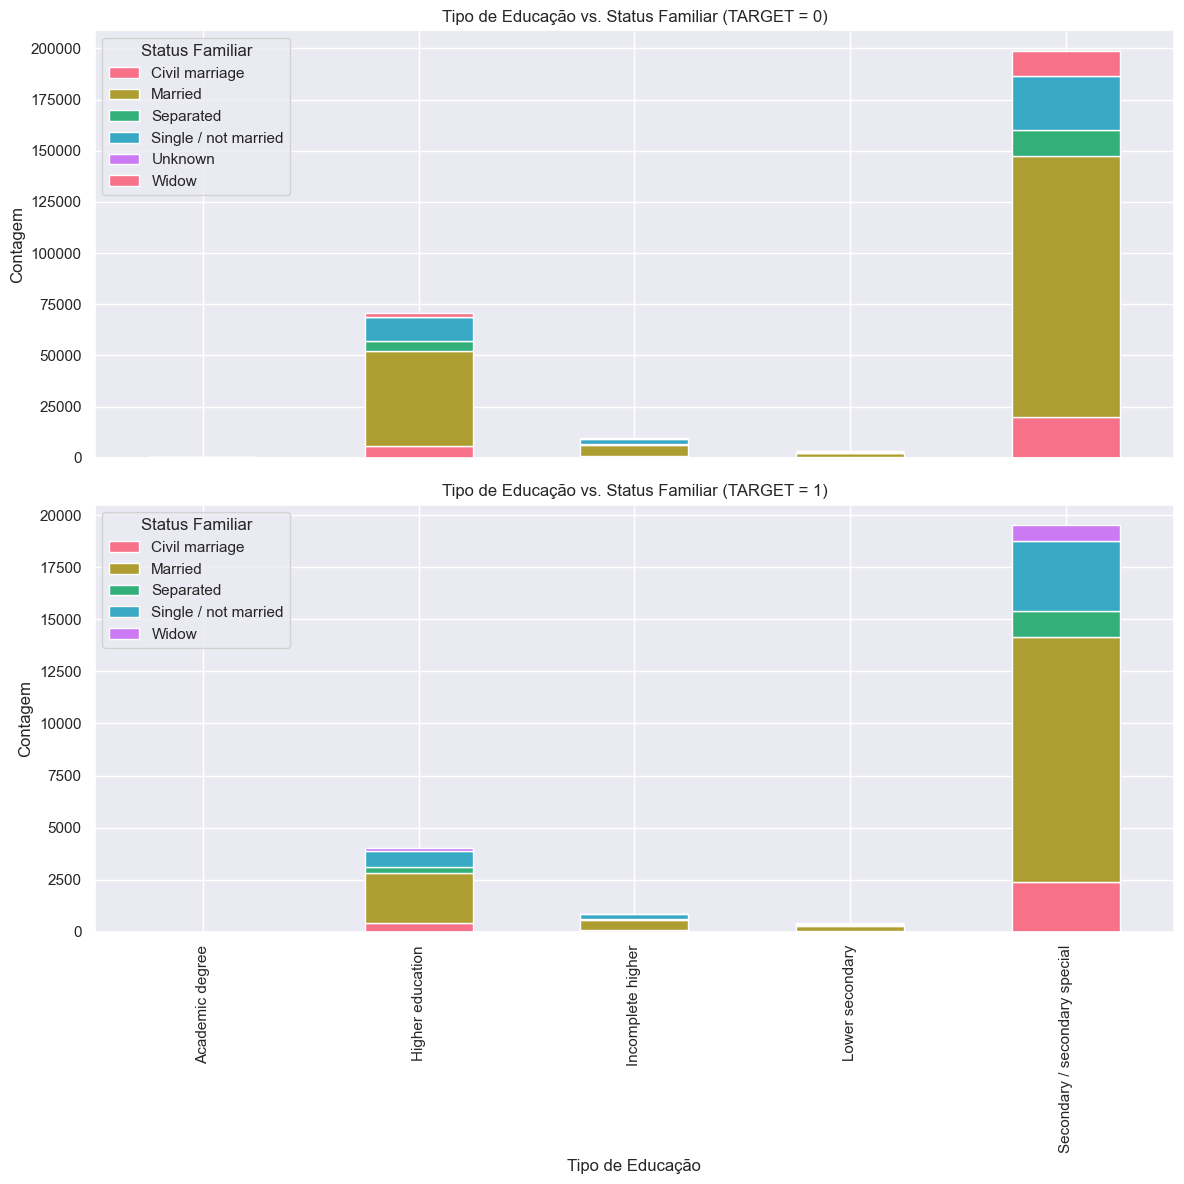

Conclusões:
- **TARGET = 0**: Indivíduos tendem a ser casados e possuem níveis educacionais mais altos.
- **TARGET = 1**: A distribuição do estado civil é mais variada, com maior presença de solteiros. 
- **Níveis Educacionais**: Ambos os grupos apresentam uma diversidade de níveis educacionais, indicando uma mistura de indivíduos com diferentes formações.



In [18]:
# Define the colors for categories
colors = sns.color_palette("husl", n_colors=len(df['TIPO_EDUCACAO'].unique()))

# Filtra o DataFrame para valores de 'TARGET' 0 e 1
df_target_0 = df[df['TARGET'] == 0]
df_target_1 = df[df['TARGET'] == 1]

# Cria gráficos de barras empilhadas para cada subconjunto
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Gráfico para TARGET = 0
crosstab_result_0 = pd.crosstab(index=df_target_0['TIPO_EDUCACAO'], columns=df_target_0['STATUS_FAMILIAR'])
crosstab_result_0.plot(kind='bar', stacked=True, ax=axs[0], color=colors)
axs[0].set_title('Tipo de Educação vs. Status Familiar (TARGET = 0)')
axs[0].set_ylabel('Contagem')
axs[0].legend(title='Status Familiar')


# Gráfico para TARGET = 1
crosstab_result_1 = pd.crosstab(index=df_target_1['TIPO_EDUCACAO'], columns=df_target_1['STATUS_FAMILIAR'])
crosstab_result_1.plot(kind='bar', stacked=True, ax=axs[1], color=colors)
axs[1].set_title('Tipo de Educação vs. Status Familiar (TARGET = 1)')
axs[1].set_ylabel('Contagem')
axs[1].set_xlabel('Tipo de Educação')
axs[1].legend(title='Status Familiar')

plt.tight_layout()
plt.show()

# Resumo das conclusões
print('Conclusões:')
print('''- **TARGET = 0**: Indivíduos tendem a ser casados e possuem níveis educacionais mais altos.''')
print('''- **TARGET = 1**: A distribuição do estado civil é mais variada, com maior presença de solteiros. 
- **Níveis Educacionais**: Ambos os grupos apresentam uma diversidade de níveis educacionais, indicando uma mistura de indivíduos com diferentes formações.
''')


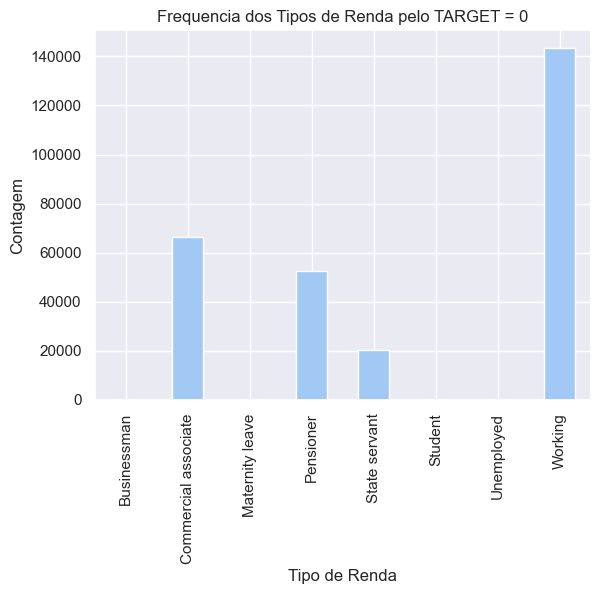

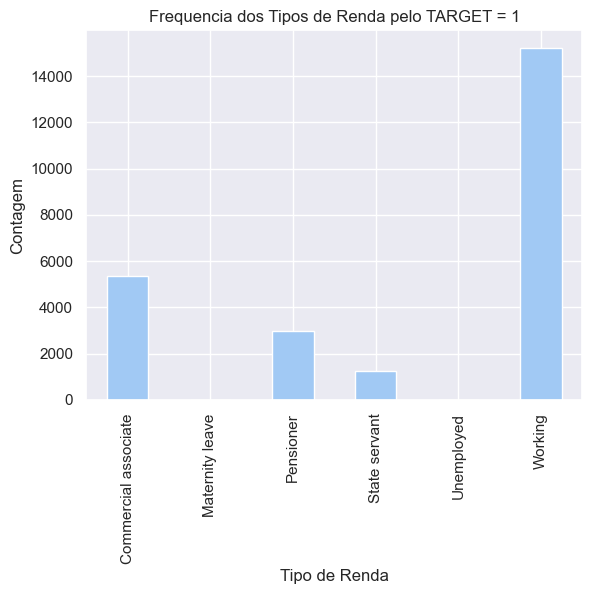

In [19]:
income_type_counts_0 = df_target_0.groupby('TIPO_RENDA').size()
income_type_counts_1 = df_target_1.groupby('TIPO_RENDA').size()

# Plot for TARGET = 0
income_type_counts_0.plot(kind='bar', stacked=True)
plt.title('Frequencia dos Tipos de Renda pelo TARGET = 0')
plt.xlabel('Tipo de Renda')
plt.ylabel('Contagem')
plt.show()

# Plot for TARGET = 1
income_type_counts_1.plot(kind='bar', stacked=True)
plt.title('Frequencia dos Tipos de Renda pelo TARGET = 1')
plt.xlabel('Tipo de Renda')
plt.ylabel('Contagem')
plt.show()

- Análise 8: Tipo de Educacao e Status Cívil x Inadimplencia

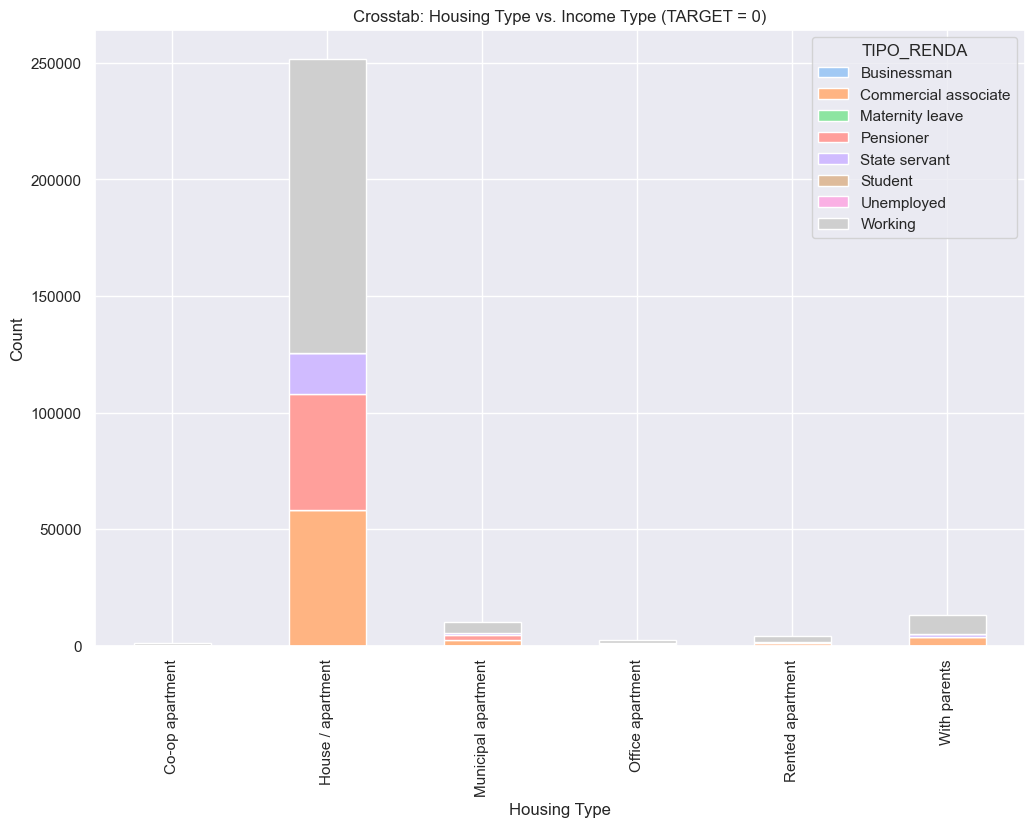

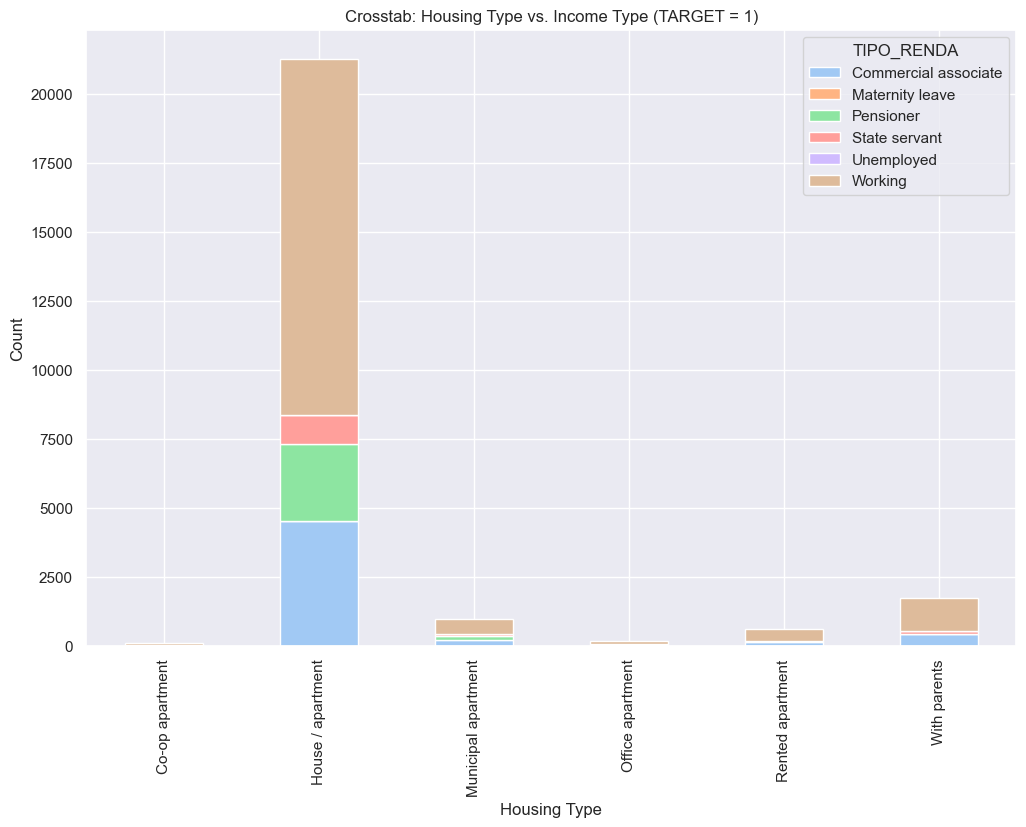

Conclusão: Casa / apartamento é o tipo de moradia preferido por indivíduos tanto em TARGET = 0 quanto em TARGET = 1. Indivíduos Trabalhando são predominantes em ambos os grupos e em diversos tipos de moradia.


In [20]:
for target_value, subset_df in [(0, df_target_0), (1, df_target_1)]:
    crosstab_result_housing_income = pd.crosstab(index=subset_df['TIPO_MORADIA'], columns=subset_df['TIPO_RENDA'])
    crosstab_result_housing_income.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title(f'Crosstab: Housing Type vs. Income Type (TARGET = {target_value})')
    plt.xlabel('Housing Type')
    plt.ylabel('Count')
    plt.show()
    
print('Conclusão: Casa / apartamento é o tipo de moradia preferido por indivíduos tanto em TARGET = 0 quanto em TARGET = 1. Indivíduos Trabalhando são predominantes em ambos os grupos e em diversos tipos de moradia.')

- Análise 9: Carro próprio e telefone x Inadimplência

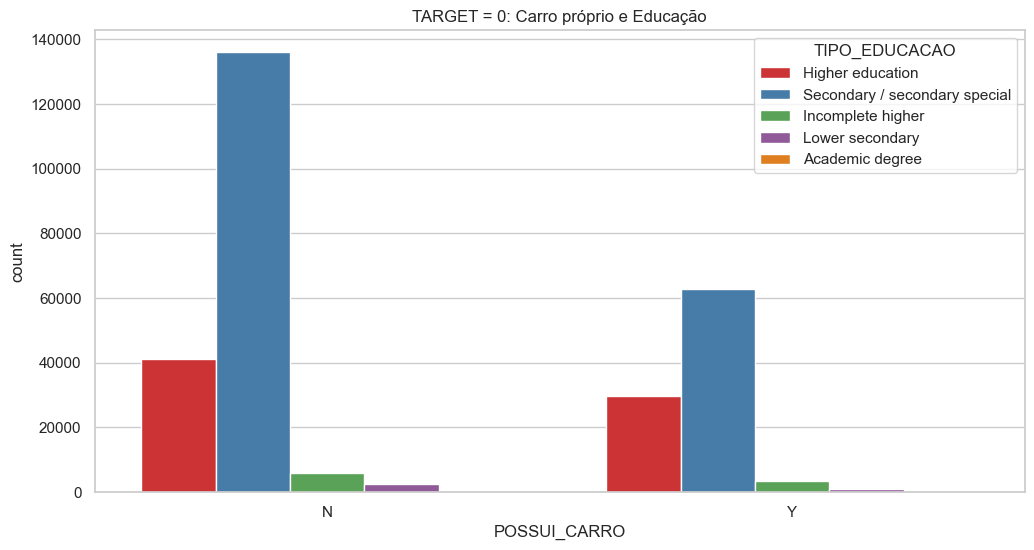

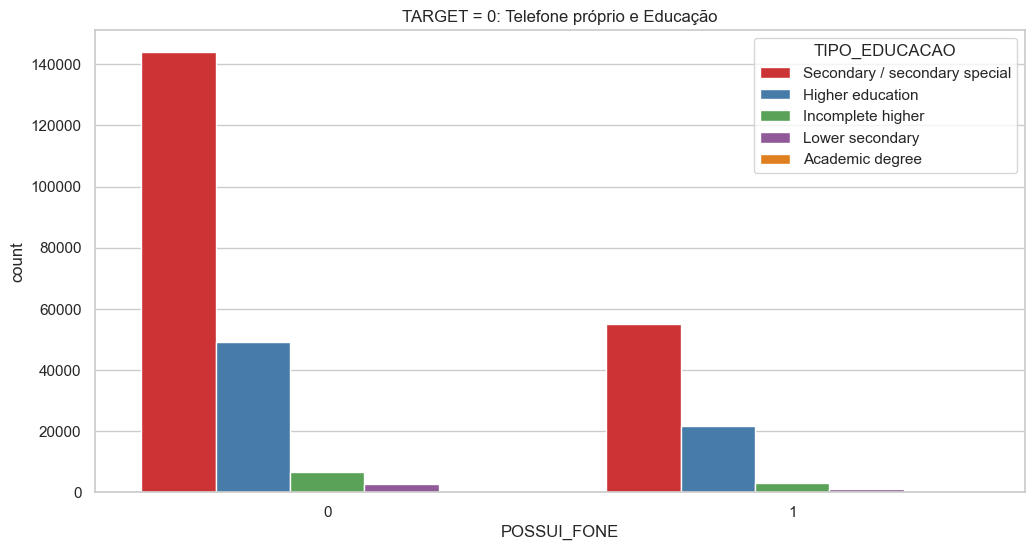

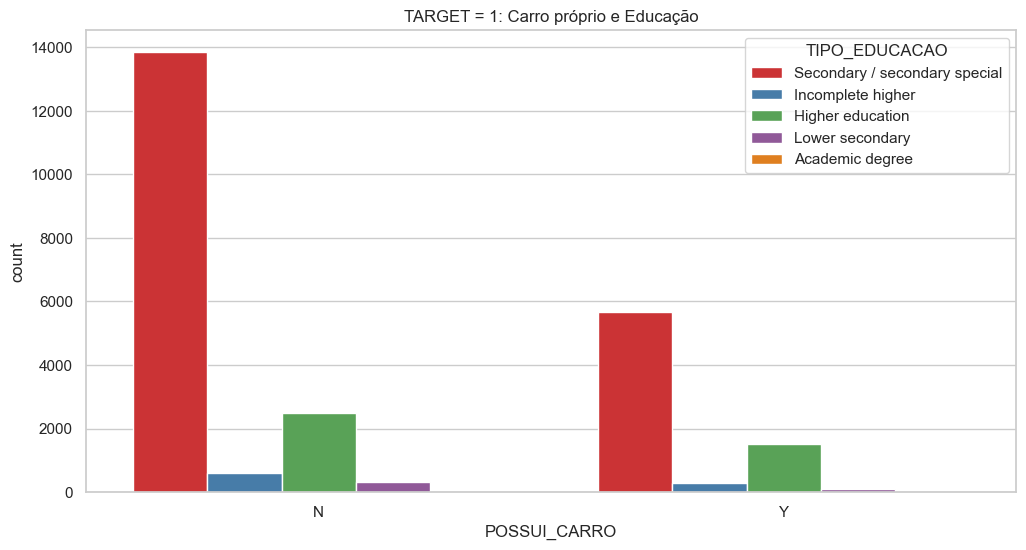

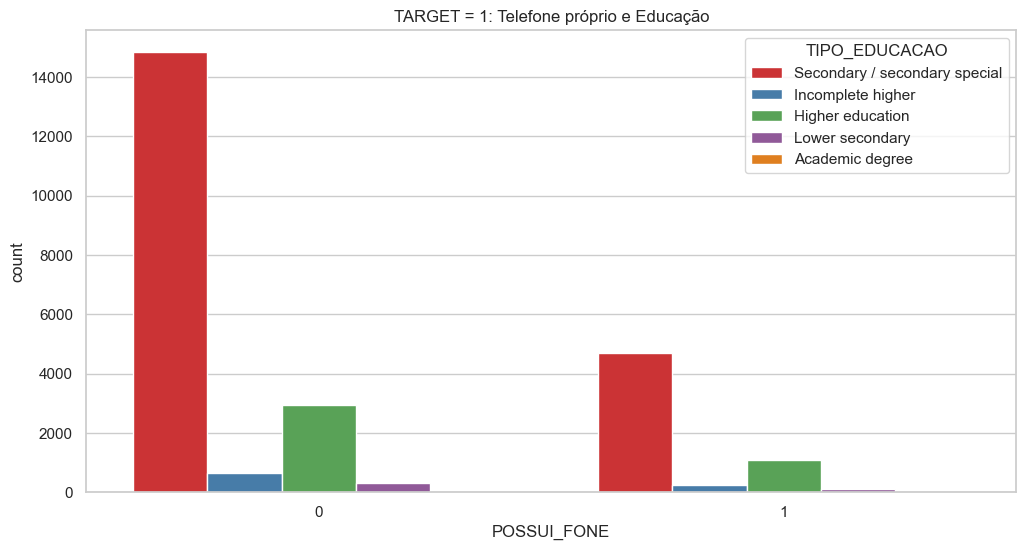

Conclusão: O tipo de educação desempenha um papel significativo tanto em empréstimos sem inadimplência quanto em inadimplentes. A educação "Secundária / secundária especial" se destaca em ambas as categorias. Ter um telefone (Has_Phone = 1) parece ser comum em ambos os tipos de empréstimos, indicando sua prevalência em todos os níveis de educação. A posse de um carro (S/N) não mostra uma distinção clara entre empréstimos sem inadimplência e inadimplentes.


In [21]:
sns.set(style="whitegrid")

# Create a grouped bar plot for TARGET = 0
plt.figure(figsize=(12, 6))
sns.countplot(x="POSSUI_CARRO", hue="TIPO_EDUCACAO", data=df[df['TARGET'] == 0], palette="Set1")
plt.title('TARGET = 0: Carro próprio e Educação')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="POSSUI_FONE", hue="TIPO_EDUCACAO", data=df[df['TARGET'] == 0], palette="Set1")
plt.title('TARGET = 0: Telefone próprio e Educação')
plt.show()

# Create a grouped bar plot for TARGET = 1
plt.figure(figsize=(12, 6))
sns.countplot(x="POSSUI_CARRO", hue="TIPO_EDUCACAO", data=df[df['TARGET'] == 1], palette="Set1")
plt.title('TARGET = 1: Carro próprio e Educação')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="POSSUI_FONE", hue="TIPO_EDUCACAO", data=df[df['TARGET'] == 1], palette="Set1")
plt.title('TARGET = 1: Telefone próprio e Educação')
plt.show()

print('Conclusão: O tipo de educação desempenha um papel significativo tanto em empréstimos sem inadimplência quanto em inadimplentes. A educação "Secundária / secundária especial" se destaca em ambas as categorias. Ter um telefone (Has_Phone = 1) parece ser comum em ambos os tipos de empréstimos, indicando sua prevalência em todos os níveis de educação. A posse de um carro (S/N) não mostra uma distinção clara entre empréstimos sem inadimplência e inadimplentes.')

- Análise 10: Mapa de Correlações

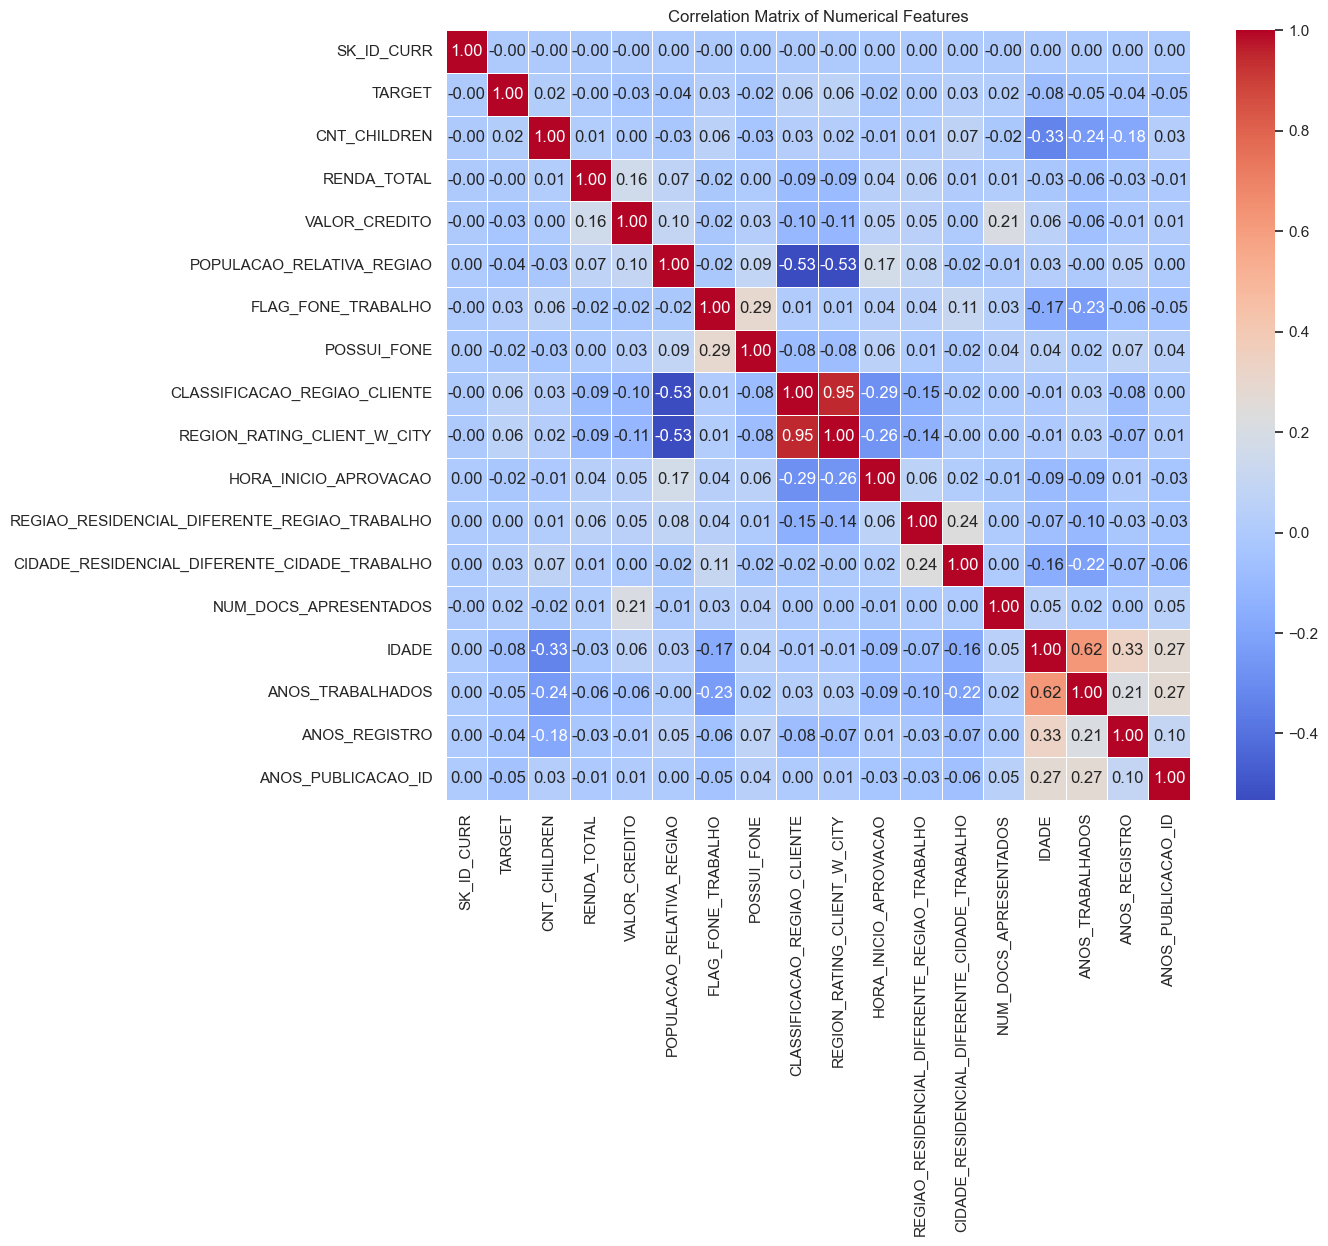

Conclusões: Devido a uma alta correlação de 0,95 entre Region_Rating_Client e Region_Rating_Client_With_City, decidi remover Region_Rating_Client_With_City para evitar redundância, simplificar e evitar multicolinearidade.


In [22]:
# Etapa 07 - Mapa de Correlações

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print('Conclusões: Devido a uma alta correlação de 0,95 entre Region_Rating_Client e Region_Rating_Client_With_City, decidi remover Region_Rating_Client_With_City para evitar redundância, simplificar e evitar multicolinearidade.')


In [23]:
column_to_drop = ['REGION_RATING_CLIENT_W_CITY']
df = df.drop(column_to_drop,axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype   
---  ------                                        --------------   -----   
 0   SK_ID_CURR                                    307507 non-null  int64   
 1   TARGET                                        307507 non-null  int64   
 2   TIPO_CONTRATO                                 307507 non-null  object  
 3   GENERO_CODIGO                                 307507 non-null  object  
 4   POSSUI_CARRO                                  307507 non-null  object  
 5   POSSUI_IMOVEL                                 307507 non-null  object  
 6   CNT_CHILDREN                                  307507 non-null  int64   
 7   RENDA_TOTAL                                   307507 non-null  float64 
 8   VALOR_CREDITO                                 307507 non-null  float64 
 9   TIPO_RENDA                                

In [25]:
df1 = df
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype   
---  ------                                        --------------   -----   
 0   SK_ID_CURR                                    307507 non-null  int64   
 1   TARGET                                        307507 non-null  int64   
 2   TIPO_CONTRATO                                 307507 non-null  object  
 3   GENERO_CODIGO                                 307507 non-null  object  
 4   POSSUI_CARRO                                  307507 non-null  object  
 5   POSSUI_IMOVEL                                 307507 non-null  object  
 6   CNT_CHILDREN                                  307507 non-null  int64   
 7   RENDA_TOTAL                                   307507 non-null  float64 
 8   VALOR_CREDITO                                 307507 non-null  float64 
 9   TIPO_RENDA                                

## ANÁLISES ESTATISTICAS

## 1. Métricas Estatísticas para Colunas Numéricas

Para variáveis numéricas, calcule as seguintes métricas:

- Média: Valor médio.
- Mediana: Valor central quando os dados são ordenados.
- Desvio Padrão: Medida da dispersão dos dados em relação à média.
- Variância: Quadrado do desvio padrão.
- Mínimo e Máximo: Valores extremos.
- Quartis e IQR (Intervalo Interquartílico): Medida de dispersão que considera a diferença entre o 1º e o 3º quartil.
- Skewness (Assimetria): Medida da simetria da distribuição.
- Kurtosis (Curtose): Medida da "altitude" da distribuição em relação a uma normal.

In [26]:
def calcular_metricas_numericas(df, colunas_numericas):
    metricas = {}
    for coluna in colunas_numericas:
        dados = df[coluna]
        metricas[coluna] = {
            'Média': dados.mean(),
            'Mediana': dados.median(),
            'Desvio Padrão': dados.std(),
            'Variância': dados.var(),
            'Mínimo': dados.min(),
            'Máximo': dados.max(),
            '1º Quartil': dados.quantile(0.25),
            '3º Quartil': dados.quantile(0.75),
            'IQR': dados.quantile(0.75) - dados.quantile(0.25),
            'Skewness': dados.skew(),
            'Kurtosis': dados.kurtosis()
        }
    return pd.DataFrame(metricas)

colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
metricas_numericas = calcular_metricas_numericas(df, colunas_numericas)
print(metricas_numericas)


                 SK_ID_CURR    TARGET  CNT_CHILDREN   RENDA_TOTAL  \
Média          2.781815e+05  0.080730      0.417047  1.687977e+05   
Mediana        2.782030e+05  0.000000      0.000000  1.471500e+05   
Desvio Padrão  1.027901e+05  0.272420      0.722119  2.371246e+05   
Variância      1.056581e+10  0.074213      0.521456  5.622809e+10   
Mínimo         1.000020e+05  0.000000      0.000000  2.565000e+04   
Máximo         4.562550e+05  1.000000     19.000000  1.170000e+08   
1º Quartil     1.891465e+05  0.000000      0.000000  1.125000e+05   
3º Quartil     3.671435e+05  0.000000      1.000000  2.025000e+05   
IQR            1.779970e+05  0.000000      1.000000  9.000000e+04   
Skewness      -1.213482e-03  3.078133      1.974634  3.915574e+02   
Kurtosis      -1.198982e+00  7.474950      7.904369  1.917843e+05   

               VALOR_CREDITO  POPULACAO_RELATIVA_REGIAO  FLAG_FONE_TRABALHO  \
Média           5.990286e+05                   0.020868            0.199358   
Mediana      

## 2. Análise de Variáveis Categóricas

Para variáveis categóricas, calcule:

- Contagem de Ocorrências: Número de observações para cada categoria.
- Proporção: Percentual de cada categoria em relação ao total.
- Distribuição: Gráficos para visualizar a distribuição de categorias.


TIPO_CONTRATO
Contagem:
TIPO_CONTRATO
Cash loans         278232
Revolving loans     29275
Name: count, dtype: int64
Proporção (%):
TIPO_CONTRATO
Cash loans         90.479892
Revolving loans     9.520108
Name: proportion, dtype: float64


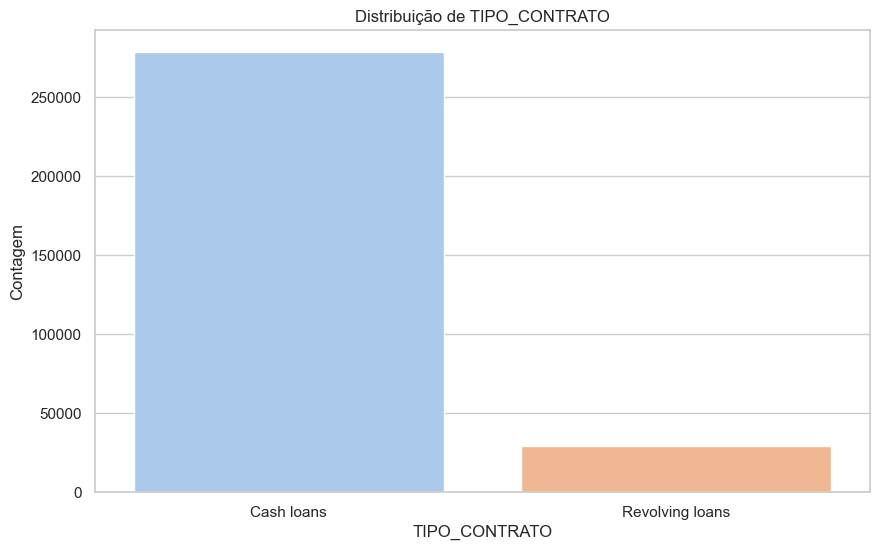


GENERO_CODIGO
Contagem:
GENERO_CODIGO
F    202448
M    105059
Name: count, dtype: int64
Proporção (%):
GENERO_CODIGO
F    65.835249
M    34.164751
Name: proportion, dtype: float64


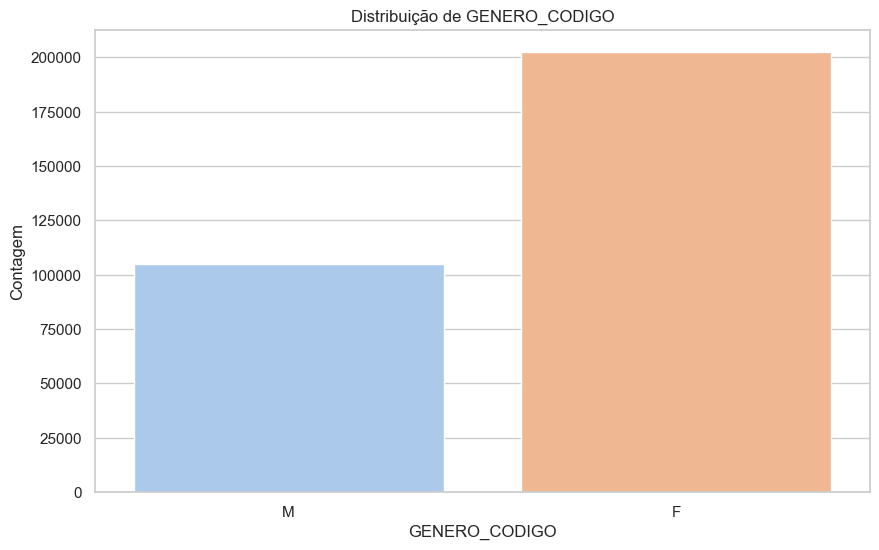


POSSUI_CARRO
Contagem:
POSSUI_CARRO
N    202922
Y    104585
Name: count, dtype: int64
Proporção (%):
POSSUI_CARRO
N    65.989392
Y    34.010608
Name: proportion, dtype: float64


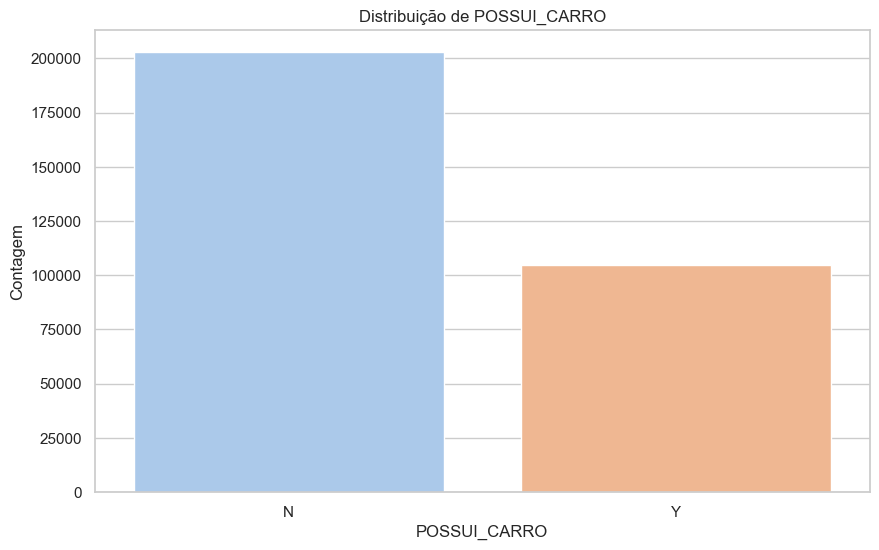


POSSUI_IMOVEL
Contagem:
POSSUI_IMOVEL
Y    213308
N     94199
Name: count, dtype: int64
Proporção (%):
POSSUI_IMOVEL
Y    69.366876
N    30.633124
Name: proportion, dtype: float64


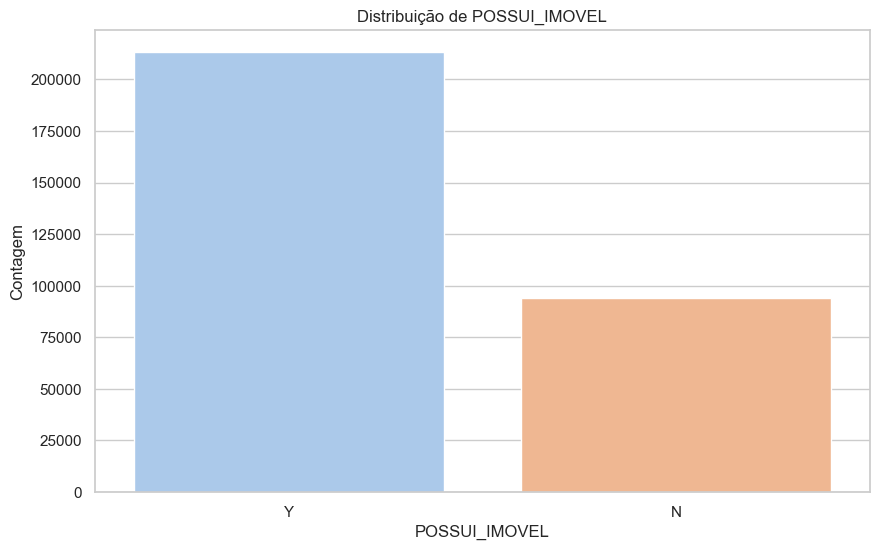


TIPO_RENDA
Contagem:
TIPO_RENDA
Working                 158771
Commercial associate     71616
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64
Proporção (%):
TIPO_RENDA
Working                 51.631670
Commercial associate    23.289226
Pensioner               18.003493
State servant            7.057726
Unemployed               0.007154
Student                  0.005854
Businessman              0.003252
Maternity leave          0.001626
Name: proportion, dtype: float64


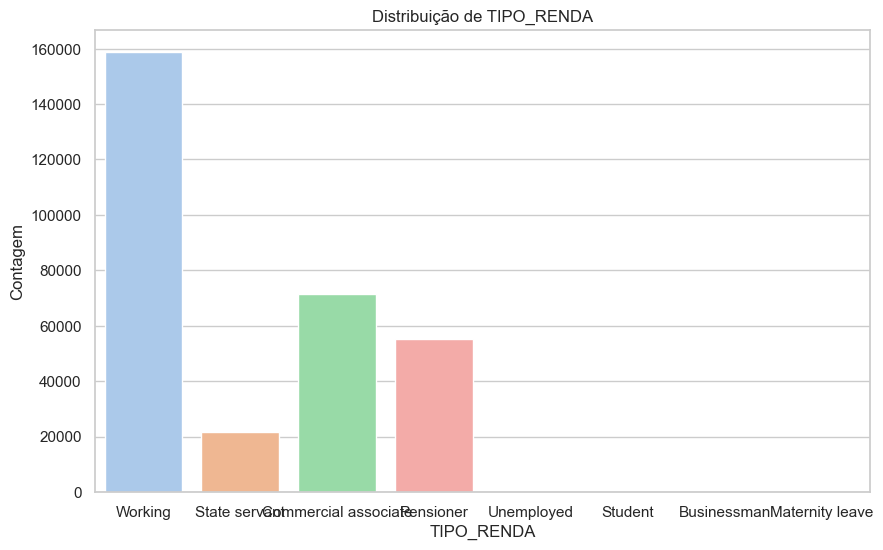


TIPO_EDUCACAO
Contagem:
TIPO_EDUCACAO
Secondary / secondary special    218389
Higher education                  74862
Incomplete higher                 10276
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64
Proporção (%):
TIPO_EDUCACAO
Secondary / secondary special    71.019196
Higher education                 24.344812
Incomplete higher                 3.341713
Lower secondary                   1.240947
Academic degree                   0.053332
Name: proportion, dtype: float64


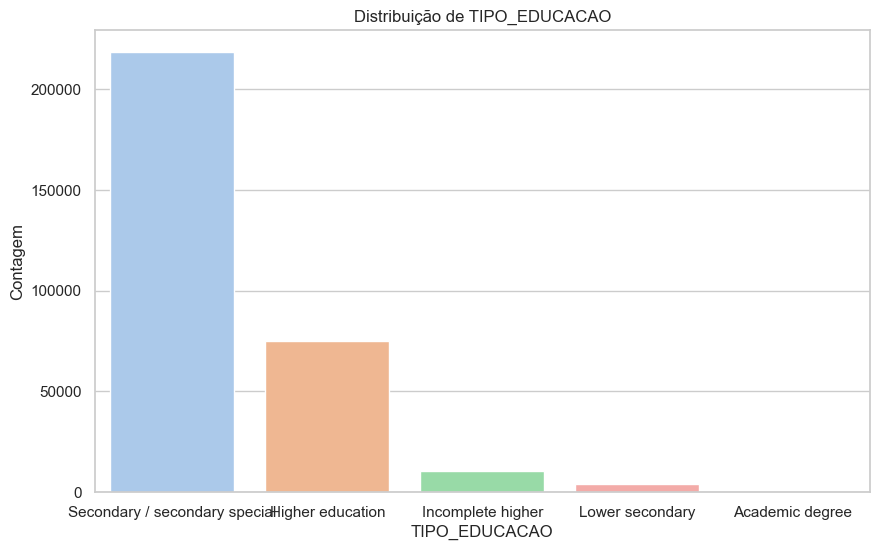


STATUS_FAMILIAR
Contagem:
STATUS_FAMILIAR
Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64
Proporção (%):
STATUS_FAMILIAR
Married                 63.877895
Single / not married    14.778200
Civil marriage           9.682381
Separated                6.429122
Widow                    5.231751
Unknown                  0.000650
Name: proportion, dtype: float64


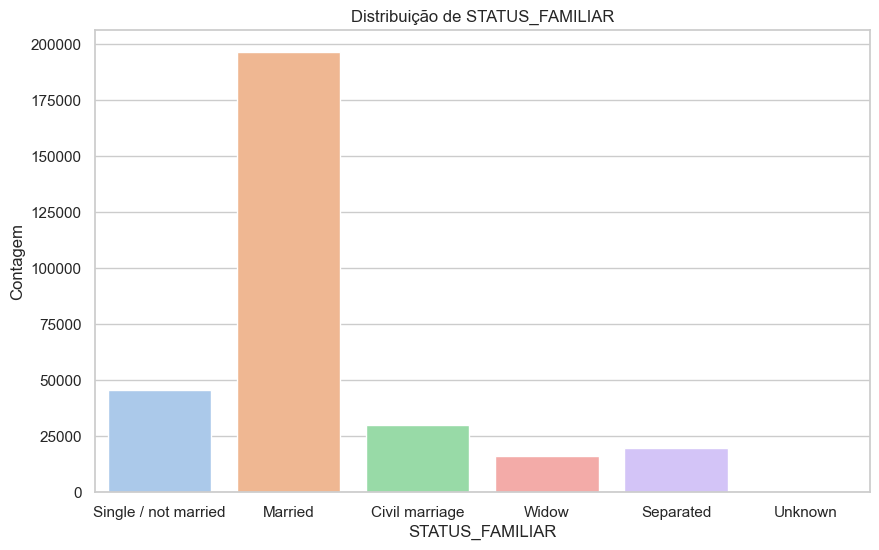


TIPO_MORADIA
Contagem:
TIPO_MORADIA
House / apartment      272865
With parents            14840
Municipal apartment     11182
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64
Proporção (%):
TIPO_MORADIA
House / apartment      88.734565
With parents            4.825906
Municipal apartment     3.636340
Rented apartment        1.587281
Office apartment        0.851038
Co-op apartment         0.364870
Name: proportion, dtype: float64


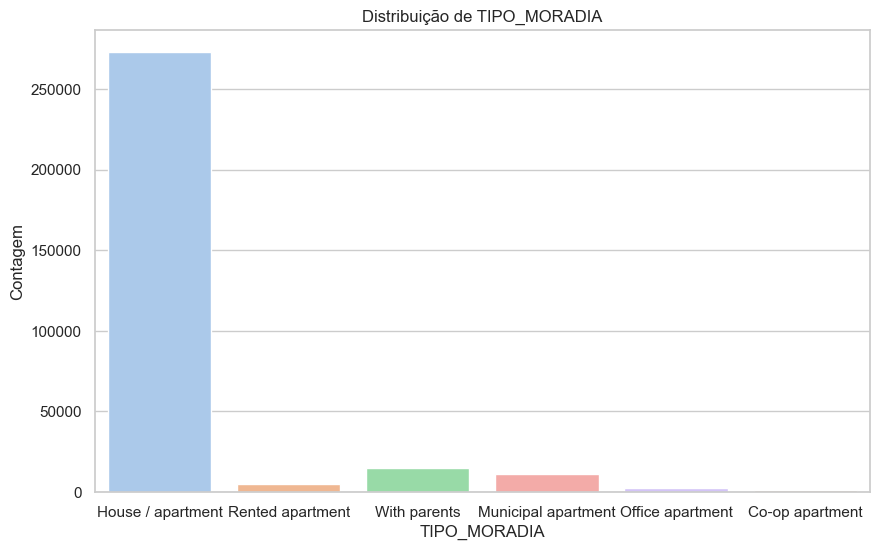


DIA_SEMANA_INICIO_APROVACAO
Contagem:
DIA_SEMANA_INICIO_APROVACAO
TUESDAY      53900
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50590
FRIDAY       50336
SATURDAY     33852
SUNDAY       16181
Name: count, dtype: int64
Proporção (%):
DIA_SEMANA_INICIO_APROVACAO
TUESDAY      17.528056
WEDNESDAY    16.888721
MONDAY       16.491982
THURSDAY     16.451658
FRIDAY       16.369058
SATURDAY     11.008530
SUNDAY        5.261994
Name: proportion, dtype: float64


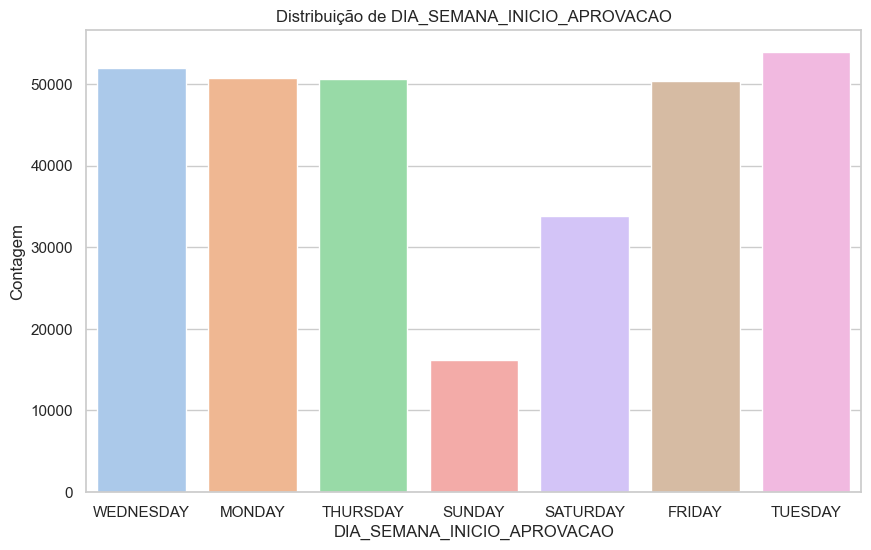


TIPO_ORGANIZACAO
Contagem:
TIPO_ORGANIZACAO
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 

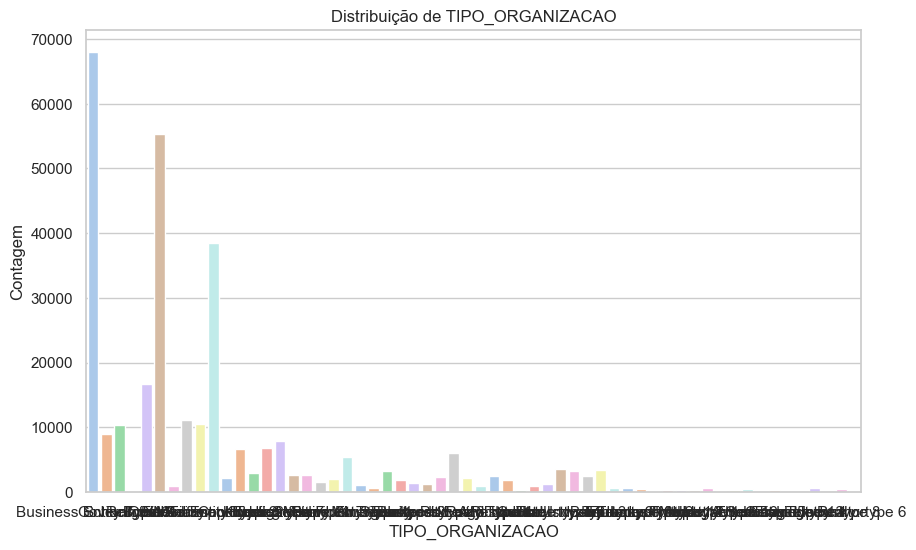


FAIXA_RENDA
Contagem:
FAIXA_RENDA
Alta          155896
Muito Alta     85211
Média          59181
Baixa           4517
Extrema         2702
Name: count, dtype: int64
Proporção (%):
FAIXA_RENDA
Alta          50.696732
Muito Alta    27.710264
Média         19.245416
Baixa          1.468910
Extrema        0.878679
Name: proportion, dtype: float64


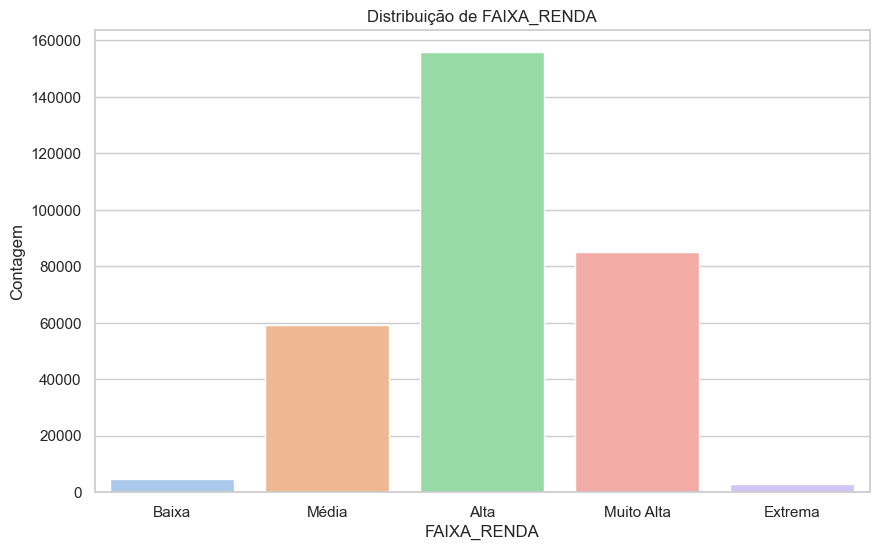


FAIXA_CREDITO
Contagem:
FAIXA_CREDITO
Alto          113186
Muito Alto    108192
Extremo        49985
Médio          30140
Baixo           6004
Name: count, dtype: int64
Proporção (%):
FAIXA_CREDITO
Alto          36.807617
Muito Alto    35.183589
Extremo       16.254915
Médio          9.801403
Baixo          1.952476
Name: proportion, dtype: float64


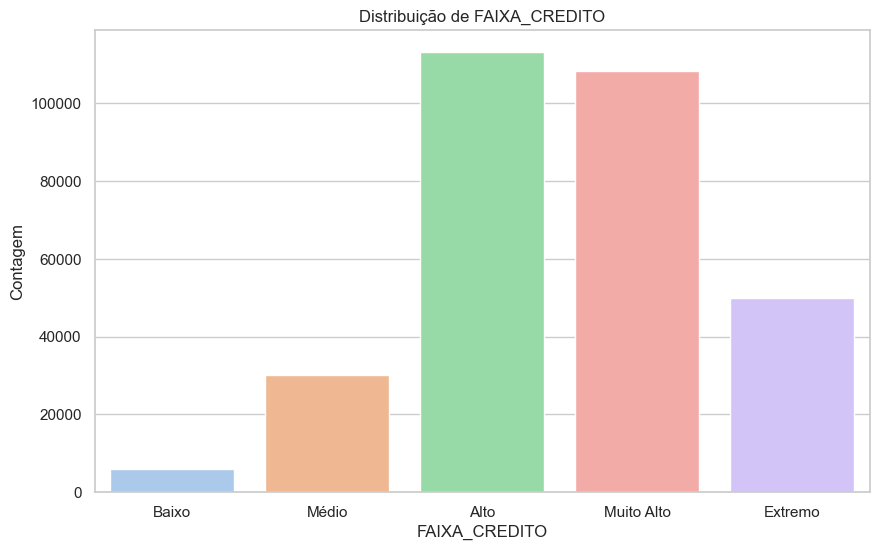

In [27]:
def analisar_variaveis_categoricas(df, colunas_categoricas):
    for coluna in colunas_categoricas:
        contagem = df[coluna].value_counts()
        proporcao = df[coluna].value_counts(normalize=True) * 100
        
        print(f'\n{coluna}')
        print(f'Contagem:\n{contagem}')
        print(f'Proporção (%):\n{proporcao}')

        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=coluna, palette='pastel')
        plt.title(f'Distribuição de {coluna}')
        plt.xlabel(coluna)
        plt.ylabel('Contagem')
        plt.show()

colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns
analisar_variaveis_categoricas(df, colunas_categoricas)


### Classificação das Colunas

| #   | Coluna                                           | Tipo de Dado | Classificação   |
|-----|--------------------------------------------------|--------------|-----------------|
| 0   | SK_ID_CURR                                       | int64        | Numérica        |
| 1   | TARGET                                           | int64        | Numérica        |
| 2   | TIPO_CONTRATO                                    | object       | Categórica      |
| 3   | GENERO_CODIGO                                    | object       | Categórica      |
| 4   | POSSUI_CARRO                                     | object       | Categórica      |
| 5   | POSSUI_IMOVEL                                    | object       | Categórica      |
| 6   | CNT_CHILDREN                                     | int64        | Numérica        |
| 7   | RENDA_TOTAL                                      | float64      | Numérica        |
| 8   | VALOR_CREDITO                                    | float64      | Numérica        |
| 9   | TIPO_RENDA                                       | object       | Categórica      |
| 10  | TIPO_EDUCACAO                                    | object       | Categórica      |
| 11  | STATUS_FAMILIAR                                  | object       | Categórica      |
| 12  | TIPO_MORADIA                                     | object       | Categórica      |
| 13  | POPULACAO_RELATIVA_REGIAO                        | float64      | Numérica        |
| 14  | FLAG_FONE_TRABALHO                               | int64        | Numérica        |
| 15  | POSSUI_FONE                                      | int64        | Numérica        |
| 16  | CLASSIFICACAO_REGIAO_CLIENTE                     | int64        | Numérica        |
| 17  | DIA_SEMANA_INICIO_APROVACAO                      | object       | Categórica      |
| 18  | HORA_INICIO_APROVACAO                            | int64        | Numérica        |
| 19  | REGIAO_RESIDENCIAL_DIFERENTE_REGIAO_TRABALHO     | int64        | Numérica        |
| 20  | CIDADE_RESIDENCIAL_DIFERENTE_CIDADE_TRABALHO     | int64        | Numérica        |
| 21  | TIPO_ORGANIZACAO                                 | object       | Categórica      |
| 22  | NUM_DOCS_APRESENTADOS                            | int64        | Numérica        |
| 23  | IDADE                                            | int64        | Numérica        |
| 24  | ANOS_TRABALHADOS                                 | int64        | Numérica        |
| 25  | ANOS_REGISTRO                                    | float64      | Numérica        |
| 26  | ANOS_PUBLICACAO_ID                               | int64        | Numérica        |
| 27  | FAIXA_RENDA                                      | category     | Categórica      |
| 28  | FAIXA_CREDITO                                    | category     | Categórica      |


## 3. Identificação de Distribuições Estatísticas

Para identificar distribuições estatísticas que melhor representam suas variáveis, você pode usar:

- Histogramas: Para observar a distribuição dos dados.
- Gráficos QQ: Para comparar a distribuição dos dados com uma distribuição teórica (normal, exponencial, etc.).
- Testes de Normalidade: Como o teste de Shapiro-Wilk ou Kolmogorov-Smirnov.

In [28]:
from scipy import stats

def analisar_distribuicoes(df, colunas_numericas):
    for coluna in colunas_numericas:
        dados = df[coluna]
        
        # Teste de Normalidade
        _, p_value = stats.shapiro(dados)
        print(f'\n{coluna} -Análise Normal: p-valor do teste de Shapiro-Wilk: {p_value:.4f}')

colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
analisar_distribuicoes(df, colunas_numericas)



SK_ID_CURR -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

TARGET -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

CNT_CHILDREN -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

RENDA_TOTAL -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

VALOR_CREDITO -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

POPULACAO_RELATIVA_REGIAO -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

FLAG_FONE_TRABALHO -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

POSSUI_FONE -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

CLASSIFICACAO_REGIAO_CLIENTE -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

HORA_INICIO_APROVACAO -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

REGIAO_RESIDENCIAL_DIFERENTE_REGIAO_TRABALHO -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

CIDADE_RESIDENCIAL_DIFERENTE_CIDADE_TRABALHO -Análise Normal: p-valor do teste de Shapiro-Wilk: 0.0000

NUM_DOCS_APRESENTADOS -Análise Norma

Transformações de Dados

- Transformação Logarítmica: Pode ser útil para variáveis com distribuição assimétrica. Por exemplo, aplicar o logaritmo aos dados pode ajudar a normalizar a distribuição.

- Transformação de Raiz Quadrada: Pode ser útil para variáveis com uma distribuição assimétrica.

- Transformação Box-Cox: Uma transformação de potência que pode ajudar a estabilizar a variância e aproximar a normalidade.

In [ ]:
# Lista de colunas numéricas
numerical_columns = [
    'SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'RENDA_TOTAL', 'VALOR_CREDITO',
    'POPULACAO_RELATIVA_REGIAO', 'FLAG_FONE_TRABALHO', 'POSSUI_FONE',
    'CLASSIFICACAO_REGIAO_CLIENTE', 'HORA_INICIO_APROVACAO',
    'REGIAO_RESIDENCIAL_DIFERENTE_REGIAO_TRABALHO',
    'CIDADE_RESIDENCIAL_DIFERENTE_CIDADE_TRABALHO', 'NUM_DOCS_APRESENTADOS',
    'IDADE', 'ANOS_TRABALHADOS', 'ANOS_REGISTRO', 'ANOS_PUBLICACAO_ID'
]

# Função para aplicar transformação logarítmica e testar normalidade
def log_transform_and_test(df, columns):
    results = {}
    for column in columns:
        # Evita problemas com log(0) adicionando uma pequena constante
        df[f'LOG_{column}'] = np.log(df[column] + 1)

        # Teste de Shapiro-Wilk
        stat, p_value = stats.shapiro(df[f'LOG_{column}'].dropna())
        results[column] = {
            'p-valor_transformed': p_value,
            'transformed_column': f'LOG_{column}'
        }

    return results

# Aplicar a transformação e teste
transformation_results = log_transform_and_test(df, numerical_columns)

# Exibir resultados
for column, result in transformation_results.items():
    print(f'Coluna original: {column}')
    print(f'Coluna transformada: {result["transformed_column"]}')
    print(f'p-valor do teste de Shapiro-Wilk após transformação logarítmica: {result["p-valor_transformed"]:.4f}')
    print('')

# Opcional: Se quiser visualizar as colunas transformadas no DataFrame
# print(df.filter(like='LOG_').head())


In [ ]:
numerical_columns = [
    'SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'RENDA_TOTAL', 'VALOR_CREDITO',
    'POPULACAO_RELATIVA_REGIAO', 'FLAG_FONE_TRABALHO', 'POSSUI_FONE',
    'CLASSIFICACAO_REGIAO_CLIENTE', 'HORA_INICIO_APROVACAO',
    'REGIAO_RESIDENCIAL_DIFERENTE_REGIAO_TRABALHO',
    'CIDADE_RESIDENCIAL_DIFERENTE_CIDADE_TRABALHO', 'NUM_DOCS_APRESENTADOS',
    'IDADE', 'ANOS_TRABALHADOS', 'ANOS_REGISTRO', 'ANOS_PUBLICACAO_ID'
]

# Função para calcular a assimetria
def calculate_skewness(df, columns):
    results = {}
    for column in columns:
        # Cálculo da assimetria para a coluna original
        skewness_original = skew(df[column].dropna())
        
        # Cálculo da assimetria para a coluna transformada
        log_column = f'LOG_{column}'
        skewness_transformed = skew(df[log_column].dropna())
        
        results[column] = {
            'skewness_original': skewness_original,
            'skewness_transformed': skewness_transformed,
            'transformed_column': log_column
        }

    return results

# Aplicar a função para calcular a assimetria
skewness_results = calculate_skewness(df, numerical_columns)

# Exibir resultados
for column, result in skewness_results.items():
    print(f'Coluna original: {column}')
    print(f'Coluna transformada: {result["transformed_column"]}')
    print(f'Assimetria da coluna original: {result["skewness_original"]:.4f}')
    print(f'Assimetria da coluna transformada: {result["skewness_transformed"]:.4f}')
    print('')


###  Tabela 01: Análise de Simetria para as variáveis numéricas

Aqui está a tabela atualizada com os títulos modificados e a coluna de assimetria após a transformação logarítmica removida:

| Nome da Coluna | Assimetria | Interpretação Analítica |
|----------------|------------|-------------------------|
| SK_ID_CURR     | -0.0012    | Distribuição quase simétrica |
| TARGET         | 3.0781     | Fortemente assimétrica para a direita |
| CNT_CHILDREN   | 1.9746     | Assimétrica para a direita |
| RENDA_TOTAL    | 391.5555   | Extremamente assimétrica para a direita |
| VALOR_CREDITO  | 1.2348     | Assimétrica para a direita |
| POPULACAO_RELATIVA_REGIAO | 1.4880 | Assimétrica para a direita |
| FLAG_FONE_TRABALHO | 1.5050 | Assimétrica para a direita |
| POSSUI_FONE    | 0.9741     | Assimétrica para a direita |
| CLASSIFICACAO_REGIAO_CLIENTE | 0.0875 | Quase simétrica |
| HORA_INICIO_APROVACAO | -0.0280 | Quase simétrica |
| REGIAO_RESIDENCIAL_DIFERENTE_REGIAO_TRABALHO | 4.6516 | Extremamente assimétrica para a direita |
| CIDADE_RESIDENCIAL_DIFERENTE_CIDADE_TRABALHO | 1.6698 | Assimétrica para a direita |
| NUM_DOCS_APRESENTADOS | -1.0146 | Assimétrica para a esquerda |
| IDADE          | 0.1162     | Quase simétrica |
| ANOS_TRABALHADOS | 1.6643    | Assimétrica para a direita |
| ANOS_REGISTRO   | 0.5934     | Assimétrica para a direita |
| ANOS_PUBLICACAO_ID | -0.3385  | Assimétrica para a esquerda |